# Laboratorio 1
## Microestructuras y Sistemas de Trading
### Valentina Escobar y Pablo Mendoza y HOLA

El presente laboratorio tiene como objetivo analizar el comportamiento de un ETF de acuerdo a la conformación de este y al movimiento de los precios que se presentaron entre el primero de Abril del 2017 hasta el 27 de Marzo del 2018 con el fin de identificar que tan conveniente es para un inversionista rebalancear el portafolio mensualmente o si por el contrario se debería cambiar la ponderación y los activos que este contiene de manera anual o al menos una vez al año. Para lograr este objetivo, se realizan diferentes medidas de desempeño que permitan comparar los portafolios resultantes.

## Primera Parte: Rebalanceos Mensuales

In [1]:
# Librerias
import quandl
import datetime
import numpy as np
import pandas as pd
import scipy.stats as stats

In [2]:
quandl.ApiConfig.api_key = "My9ygJsz7yTDx_9jcneH" # Quandl API key
fechas = list(['2017-04-28','2017-05-31','2017-06-30','2017-07-31','2017-08-31','2017-09-29','2017-10-31','2017-11-30','2017-12-29','2018-01-31','2018-02-28','2018-03-27'])

In [3]:
# Funcion que descargue los precios de QuandL
def Download_QuandL(fechas:'Dates_list ', num_archivos:'number of archives'):
    d2 = {} # Crea un Diccionario Vacío
    for i in range(num_archivos): # cilco que descarga los datos de Quandl y los guarda como DataFrames en un Diccionario
        nom = "Data_"+str(i+1)
        tickerr = list(d[nom]["Ticker"])
        date = { 'gte': fechas[i], 'lte': fechas[i] }
        column = { 'columns': ['ticker', 'date', 'Adj_close']}
        data = quandl.get_table('WIKI/PRICES', qopts = column, ticker = tickerr, date = date, paginate=True)# ticker = 'WIKI/AAPL' #'AAPL.US'
        d2["Data_{0}".format(i+1)] = data.set_index('ticker')
        d[nom] = d[nom].set_index('Ticker') #El indice es el Ticker
    return d2
# Función qu eguarde los exceles en un diccionario y que los limpie
def Download_Excel_csv(num_archivos:'Number of documents', dir_:'Directory', f_name:'File name prefix' ):
    d = {} # Crea un Diccionario Vacío
    for i in range(num_archivos): # cilco que importa los CSV y los guarda como DataFrames en un Diccionario
        nom_arch = f_name+str(i+1)+".csv"    
        dir_f = dir_+nom_arch
        data = pd.read_csv(dir_f, skiprows = [0,1,2,3,4,5,6,7,8,9])
        d["Data_{0}".format(i+1)] = data#.set_index('Ticker')
    return d
# Funcion que elimina datos que no coinciden de Quandl y iShares
def Clean_Data(num_archivos:'', d:'Dictionary of Excel', d2:'Dictionary of QuandL'):
    d3 = {} # Crea un Diccionario Vacío
    for i in range(num_archivos):
        nom = "Data_"+str(i+1)
        a = set(list(d[nom].index))
        b = set(list(d2[nom].index))
        c = list(a-b) #compara los que hay en el CSV y en Quandl y asi quitarlos
        data_1 = d[nom]
        data_2 = d2[nom]
        data_1 = data_1.drop(c, axis = 0) #elimina los activos que QuandL no tiene
        data_1 = data_1.drop(["Name","Asset Class", "Market Value", "Shares", "Notional Value", "Sector", "SEDOL", "ISIN", "Exchange"],1)
        data = data_1.join(data_2)
        data = data.drop("date", axis = 1)
        data.columns = (["Weight","Start", "End"])
        data['Start'] = data['Start'].str.replace(',', '')
        data['Weight'] = data['Weight']/100
        data['Start'] = pd.to_numeric(data['Start'])
        d3["Data_{0}".format(i+1)] = data
    return d3
def Shares(d:'Data Frame',Capital_Inicial:'Capital Inicial'):
    shares = pd.DataFrame(np.floor((d3['Data_1']['Weight']*Capital_Inicial)/d3['Data_1']['Start']), columns = ['Shares'])
    d = d.join(shares)
    return d
# Listas
def listas(a, b):
    lista_final = []
    for i in a:
        if (i not in lista_final) and (i in b):
            lista_final.append(i)
    return lista_final

In [4]:
d = Download_Excel_csv(12,"/Users/pablomendoza/Documents/ITESO/Trading/Lab_1/Trading/Data/","IJH_holdings-" )
d2 = Download_QuandL(fechas,12)
d3 = Clean_Data(12, d, d2)              
Cap_Men = list()
Capital_Inicial = 48000000000 # cien melones
Costo_Transaccion = 0.0003#se cobra el % de lo que se compra o vende
Capital = Capital_Inicial
for i in range(12):
    nom = "Data_"+str(i+1)
    d3["Data_{0}".format(i+1)] = Shares(d3[nom],Capital_Inicial)

In [20]:
# Funciones del Rebalanceo
def rebalanceo(d_1,d_2,fechas,costo,dif_rebal,cant_rebal,Cap_In):
    # Calcular el Valor del Portafolio
    val_port = (d_1["Shares"]*d_1["Start"]).sum() # Calor del protafolio incial
    Sobrante = Cap_In - val_port 
    # Ver diferencias entre tickers
    #Vender acciones
    a = list(set(list(d_1.index))-set(list(d_2.index)))
    for i in range(len(d_1)):
        for j in range(len(a)):
            if a[j] == list(d_1.index)[i]:
                value = d_1.iloc[i,2]*d_1.iloc[i,3]
                Sobrante += value - costo*value              
            else:
                pass
    d_1 = d_1.drop(a,0)
    #Comprar acciones
    b = list(set(list(d_2.index))-set(list(set(list(d_2.index))-set(list(d_1.index)))))
    d_app = d_2.drop(b)
    d_app = Shares(d_app, Cap_In)
    d_2 = d_2.join(d_app)
    
    
    for i in range(len(d_1)):
        for j in range(len(a)):
            if a[j] == list(d_1.index)[i]:
                value = d_1.iloc[i,2]*d_1.iloc[i,3]
                Sobrante += value - costo*value              
            else:
                pass
    
    
    return

In [5]:
b = list(set(list(d3["Data_2"].index))-set(list(d3["Data_1"].index)),1)
print(b)

['UBSI', 'PBF', 'ACHC']


In [7]:
del_1 = d3["Data_2"].index

In [11]:
borr = list(set(list(del_1))-set(list(set(list(d3["Data_2"].index))-set(list(d3["Data_1"].index)))))
d3["Data_2"].drop(borr)

,Weight,Start,End,Shares
Ticker,,,,
UBSI,0.0025,39.90,37.537942,NaN
ACHC,0.0020,43.58,41.340000,NaN
PBF,0.0015,22.32,19.049916,NaN


In [4]:
Cap_Men = list()
etf_valuee = list()

shares = list()
    pesos = list()
    starts = list()
    ends = list()

In [5]:



    ################# PASO 2: Si un activo aparece de un mes a otro: COMPRAR PONDERACION DE ESE ACTIVO
    
    for b in range(len(data_2)):
        for k in range(len(d)):
            if d[k] == list(data_2.index)[b]:
                dato = data_2[b:b+1]
                ponde = (np.float(dato.loc[[d[k]][0]]['Weight']))/100 # obtiene la ponderacion del activo k
                i_shares = np.abs(np.floor((ponde*Capital_Inicial)/(np.float(dato.loc[[d[k]][0]][1])))) # obtiene el numero de accciones
                sobra = (ponde*Capital_Inicial)%(np.float(dato.loc[[d[k]][0]][1])) #obtiene el sobrante de la compra de acciones
                shares.append(i_shares)
                Capital = Capital - ((ponde)*Capital_Inicial) + sobra - Costo_Transaccion*((ponde)*Capital_Inicial)
                peso = dato.loc[[d[k]][0]]['Weight']
                start = dato.loc[[d[k]][0]][1]
                end = dato.loc[[d[k]][0]][2]
                pesos.append(peso)
                starts.append(start)
                ends.append(end)
            else:
                pass
    shares = pd.DataFrame(shares, columns = ['Shares']) #convierte a DF el numero de acciones
    ends = pd.DataFrame(ends, columns = ['End'])
    starts = pd.DataFrame(starts, columns = ['Start'])
    pesos = pd.DataFrame(pesos, columns = ['Weight'])
    nom = pd.DataFrame(d, columns = ['Ticker'])
    nom = nom.join(pesos)
    nom = nom.join(starts)
    nom = nom.join(ends)
    nom = nom.join(shares)
    data_1 = data_1.reset_index()
    data_1 = pd.concat([nom,data_1], axis=0)
    d5["Data_{0}".format(i+1)] = data_1
    ################## PASO 3: Rebalancear segun cambios en la ponderación
    for s in range(len(data_1)):
        for x in range(len(e)):
            if data_1.iloc[s,0] == e[x]:
                if float(data_1.iloc[s,1]) == float(data_2.loc[[data_1.iloc[s,0]][0]]['Weight']):
                    data_1.iloc[s,1] = data_1.iloc[s,1]
                elif float(data_1.iloc[s,1]) >= float(data_2.loc[[data_1.iloc[s,0]][0]]['Weight']):
                    dif_w = (float(data_1.iloc[s,1]) - float(data_2.loc[[data_1.iloc[s,0]][0]]['Weight']))/100
                    dif_m = (dif_w*Capital_Inicial)
                    num_shares = np.abs(np.floor(dif_m/float(data_1.iloc[s,2])))
                    Capital = np.abs(Capital + num_shares*float(data_1.iloc[s,3]) - Costo_Transaccion*num_shares*float(data_1.iloc[s,3]))
                    data_1.iloc[s,1] = float(data_2.loc[[data_1.iloc[s,0]][0]]['Weight'])
                    data_1.iloc[s,4] = float(num_shares)
                elif float(data_1.iloc[s,1]) <= float(data_2.loc[[data_1.iloc[s,0]][0]]['Weight']):
                    dif_w = (float(data_1.iloc[s,1]) - float(data_2.loc[[data_1.iloc[s,0]][0]]['Weight']))/100
                    dif_m = (dif_w*Capital_Inicial)
                    num_shares = np.abs((np.floor(dif_m/float(data_1.iloc[s,2]))))
                    Capital = np.abs(Capital - num_shares*float(data_1.iloc[s,3]) - Costo_Transaccion*num_shares*float(data_1.iloc[s,3]))
                    data_1.iloc[s,1] = float(data_2.loc[[data_1.iloc[s,0]][0]]['Weight'])
                    data_1.iloc[s,4] = float(num_shares)
            else:
                pass
    Cap_Men.append((Capital/Real))
    ################## PASO 4: Valor del ETF
    data_1['Shares'].astype(float)
    data_1['Start'].astype(float)
    etf_value_ = ((data_1.Shares * data_1.End).sum())/data_1['Shares'].sum()
    etf_valuee.append(etf_value_)
    print('El valor del ETF mensual es de:')
    print(etf_value_)
    if i == num_archivos-2:
        print('El rendimiento del portafolio después de un año con rebalanceos mensuales es de:')
        print(Cap_Men[-1])

El valor del ETF mensual es de:
42.82708754042826
El valor del ETF mensual es de:
38.912968897287655
El valor del ETF mensual es de:
40.10107559824865
El valor del ETF mensual es de:
39.66302307955254
El valor del ETF mensual es de:
40.50423064816577
El valor del ETF mensual es de:
44.6513597993898
El valor del ETF mensual es de:
48.12742808165386
El valor del ETF mensual es de:
47.176943009363114
El valor del ETF mensual es de:
45.148401171075875
El valor del ETF mensual es de:
45.54357355710662
El valor del ETF mensual es de:
40.091158476286246
El rendimiento del portafolio después de un año con rebalanceos mensuales es de:
0.003263726538276426


## Segunda Parte: Rebalanceo Mes-Año

A continuación, se crean diferentes portafolios los cuales son rebalanceados una vez al año en diferentes meses en el periodo de tiempo anteriormente establecido. 

# 1-12

In [10]:
# Importa los datos de Excel y los guarda en un diccionario llamado "d"
d = {} # Crea un Diccionario Vacío
quandl.ApiConfig.api_key = "My9ygJsz7yTDx_9jcneH" # Quandl API key
num_archivos = 2
for i in range(num_archivos): # cilco que importa los CSV y los guarda como DataFrames en un Diccionario
    nom_arch = "IJH_holdings-"+str(i+1)+".csv"    
    dir_f = "/Users/Valentina/Desktop/ITESO/Trading/Trading/Trading/Data/"+nom_arch
    data = pd.read_csv(dir_f, skiprows = [0,1,2,3,4,5,6,7,8,9])
    d["Data_{0}".format(i+1)] = data#.set_index('Ticker')
# Importa los datos de Quandl y los guarda en un diccionario llamado "d2"
d2 = {} # Crea un Diccionario Vacío
fechass = list(['2017-04-28','2018-03-27']) #'2017-04-28','2017-05-31','2017-06-30','2017-07-31','2017-08-31','2017-09-29','2017-10-31','2017-11-30','2017-12-29','2018-01-31','2018-02-28','2018-03-27'
for i in range(num_archivos): # cilco que descarga los datos de Quandl y los guarda como DataFrames en un Diccionario
    nom = "Data_"+str(i+1)
    tickerr = list(d[nom]["Ticker"])
    date = { 'gte': fechass[i], 'lte': fechass[i] }
    column = { 'columns': ['ticker', 'date', 'Adj_close']}
    data = quandl.get_table('WIKI/PRICES', qopts = column, ticker = tickerr, date = date, paginate=True)# ticker = 'WIKI/AAPL' #'AAPL.US'
    d2["Data_{0}".format(i+1)] = data.set_index('ticker')
    d[nom] = d[nom].set_index('Ticker') #El indice es el Ticker
# Crea un diccionario de portafolio mensual con los datos de compra y venta y las ponderaciones de cada activo
d3 = {} # Crea un Diccionario Vacío
for i in range(num_archivos):
    nom = "Data_"+str(i+1)
    a = set(list(d[nom].index))
    b = set(list(d2[nom].index))
    c = list(a-b) #compara los que hay en el CSV y en Quandl y asi quitarlos
    data_1 = d[nom]
    data_2 = d2[nom]
    data_1 = data_1.drop(c, axis = 0) #elimina los activos que QuandL no tiene
    data_1 = data_1.drop(["Name","Asset Class", "Market Value", "Shares", "Notional Value", "Sector", "SEDOL", "ISIN", "Exchange"],1)
    data = data_1.join(data_2)
    data = data.drop("date", axis = 1)
    data.columns = (["Weight","Start", "End"])
    d3["Data_{0}".format(i+1)] = data
    Capital_Inicial = 48000000000 # cien melones
Costo_Transaccion = 0.0003#se cobra el % de lo que se compra o vende
Capital = Capital_Inicial
d4 = {} # Dicionario que guarda DF con [Weights, Start, End, Shares]
d5 = {} # Dicionario que guarda DF con [Weights, Start, End, Shares] removiendo las ventas y añadiendo compras
for i in range(num_archivos-1):
    nom = "Data_"+str(i+1) 
    nom_2 = "Data_"+str(i+2)
    data_1 = d3[nom] #Datos de Activos al inicio del mes 
    data_2 = d3[nom_2] #Datos de Activos al final del mes 
    data_1['Start'] = data_1['Start'].str.replace(',', '') # quita las , del archivo para poder transformarlos a numero
    data_2['Start'] = data_2['Start'].str.replace(',', '')
    t_1 = list(d3[nom].index) #Indices de Activos al inicio del mes 
    t_2 = list(d3[nom_2].index) #Indices de Activos al final del mes 
    a = set(list(d3[nom].index))
    b = set(list(d3[nom_2].index))
    c = list(a-b) #Diferencias entre los activos de Cada Mes quitar del mes 1
    d = list(b-a) #Diferencias entre los activos de Cada Mes agregar del mes 1 a 2
    e = listas(t_1, t_2)
    try:
        c.remove('\xa0') # Quita el Activo inexistente, pero si de archivo
    except:
        pass
    ################## Tenemos Dinero y Compramos los Activos calculando el numero de Acciones de Cada Uno
    shares = list() #lista vacía para el numero de acciones de cada activo
    for j in range(len(data_1)):
        ponde = np.float(d3[nom].loc[[t_1[j]][0]]['Weight'])/100 # obtiene la ponderacion del activo j
        i_shares = np.abs(np.floor((ponde*Capital_Inicial)/(np.float(d3[nom].loc[[t_1[j]][0]][1])))) # obtiene el numero de accciones
        #sobra = (ponde*Capital_Inicial)%(np.float(d3[nom].loc[[t_1[j]][0]][1])) #obtiene el sobrante de la compra de acciones
        shares.append(i_shares) # guarda el numero de acciones en una lista
        if i == 0:
            Capital = Capital - (i_shares*np.float(d3[nom].loc[[t_1[j]][0]][1])) - Costo_Transaccion*(i_shares*np.float(d3[nom].loc[[t_1[j]][0]][1])) #calcula el capital restante
            No_Inv = Capital
            Real = Capital_Inicial-No_Inv
            Capital = Capital - Capital
    shares = pd.DataFrame(shares, columns = ['Shares']) #convierte a DF el numero de acciones
    data_1 = data_1.reset_index()
    data_1 = data_1.join(shares)
    data_1 = data_1.set_index('Ticker')
    d4["Data_{0}".format(i+1)] = data_1 #d4 guarda DF con [Weights, Start, End, Shares] termina en el 11 por que es el ultimo rebalanceo
    ################## PASO 1: Si un activo desaparece de un mes a otro: VENDER TODO DE ESE ACTIVO
    for y in range(len(data_1)):
        for u in range(len(c)):
            if c[u] == list(data_1.index)[y]:
                value = data_1.iloc[y,2]*data_1.iloc[y,3]
                Capital += value - Costo_Transaccion*value              
            else:
                pass
    data_1 = data_1.drop(c,0)
    ################## PASO 2: Si un activo aparece de un mes a otro: COMPRAR PONDERACION DE ESE ACTIVO
    shares = list()
    pesos = list()
    starts = list()
    ends = list()
    for b in range(len(data_2)):
        for k in range(len(d)):
            if d[k] == list(data_2.index)[b]:
                dato = data_2[b:b+1]
                ponde = (np.float(dato.loc[[d[k]][0]]['Weight']))/100 # obtiene la ponderacion del activo k
                i_shares = np.abs(np.floor((ponde*Capital_Inicial)/(np.float(dato.loc[[d[k]][0]][1])))) # obtiene el numero de accciones
                sobra = (ponde*Capital_Inicial)%(np.float(dato.loc[[d[k]][0]][1])) #obtiene el sobrante de la compra de acciones
                shares.append(i_shares)
                Capital = Capital - ((ponde)*Capital_Inicial) + sobra - Costo_Transaccion*((ponde)*Capital_Inicial)
                peso = dato.loc[[d[k]][0]]['Weight']
                start = dato.loc[[d[k]][0]][1]
                end = dato.loc[[d[k]][0]][2]
                pesos.append(peso)
                starts.append(start)
                ends.append(end)
            else:
                pass
    shares = pd.DataFrame(shares, columns = ['Shares']) #convierte a DF el numero de acciones
    ends = pd.DataFrame(ends, columns = ['End'])
    starts = pd.DataFrame(starts, columns = ['Start'])
    pesos = pd.DataFrame(pesos, columns = ['Weight'])
    nom = pd.DataFrame(d, columns = ['Ticker'])
    nom = nom.join(pesos)
    nom = nom.join(starts)
    nom = nom.join(ends)
    nom = nom.join(shares)
    data_1 = data_1.reset_index()
    data_1 = pd.concat([nom,data_1], axis=0)
    d5["Data_{0}".format(i+1)] = data_1
    ################## PASO 3: Rebalancear segun cambios en la ponderación
    for s in range(len(data_1)):
        for x in range(len(e)):
            if data_1.iloc[s,0] == e[x]:
                if float(data_1.iloc[s,1]) == float(data_2.loc[[data_1.iloc[s,0]][0]]['Weight']):
                    data_1.iloc[s,1] = data_1.iloc[s,1]
                elif float(data_1.iloc[s,1]) >= float(data_2.loc[[data_1.iloc[s,0]][0]]['Weight']):
                    dif_w = (float(data_1.iloc[s,1]) - float(data_2.loc[[data_1.iloc[s,0]][0]]['Weight']))/100
                    dif_m = (dif_w*Capital_Inicial)
                    num_shares = np.abs(np.floor(dif_m/float(data_1.iloc[s,2])))
                    Capital = Capital + num_shares*float(data_1.iloc[s,3]) - Costo_Transaccion*num_shares*float(data_1.iloc[s,3])
                    data_1.iloc[s,1] = float(data_2.loc[[data_1.iloc[s,0]][0]]['Weight'])
                    data_1.iloc[s,4] = float(num_shares)
                elif float(data_1.iloc[s,1]) <= float(data_2.loc[[data_1.iloc[s,0]][0]]['Weight']):
                    dif_w = (float(data_1.iloc[s,1]) - float(data_2.loc[[data_1.iloc[s,0]][0]]['Weight']))/100
                    dif_m = (dif_w*Capital_Inicial)
                    num_shares = np.abs(np.floor(dif_m/float(data_1.iloc[s,2])))
                    Capital = Capital - num_shares*float(data_1.iloc[s,3]) - Costo_Transaccion*num_shares*float(data_1.iloc[s,3])
                    data_1.iloc[s,1] = float(data_2.loc[[data_1.iloc[s,0]][0]]['Weight'])
                    data_1.iloc[s,4] = float(num_shares)
            else:
                pass
    etf_value_an = list()
    data_1['Shares'].astype(float)
    data_1['Start'].astype(float)
    etf_value_an_ = ((data_1.Shares * data_1.End).sum())/data_1['Shares'].sum()
    etf_value_an.append(etf_value_an_)
    if i == num_archivos-2:
        print('El rendimiento del portafolio después de un año con anual es de:')
        Res_An_1 =list([0])
        Res_An_1.append((Capital/Real))
        print((Capital/Real))
    print('El valor del ETF es de:')
    print(etf_value_an_)

El rendimiento del portafolio después de un año con anual es de:
0.02656477493578439
El valor del ETF es de:
43.49296137530538


# 2-12

In [12]:
# Importa los datos de Excel y los guarda en un diccionario llamado "d"
d = {} # Crea un Diccionario Vacío
quandl.ApiConfig.api_key = "My9ygJsz7yTDx_9jcneH" # Quandl API key
num_archivos = 2
for i in range(num_archivos): # cilco que importa los CSV y los guarda como DataFrames en un Diccionario
    nom_arch = "IJH_holdings-"+str(i+1)+".csv"    
    dir_f = "/Users/Valentina/Desktop/ITESO/Trading/Trading/Trading/Data/"+nom_arch
    data = pd.read_csv(dir_f, skiprows = [0,1,2,3,4,5,6,7,8,9])
    d["Data_{0}".format(i+1)] = data#.set_index('Ticker')
# Importa los datos de Quandl y los guarda en un diccionario llamado "d2"
d2 = {} # Crea un Diccionario Vacío
fechass = list(['2017-05-31','2018-03-27']) #'2017-04-28','2017-05-31','2017-06-30','2017-07-31','2017-08-31','2017-09-29','2017-10-31','2017-11-30','2017-12-29','2018-01-31','2018-02-28','2018-03-27'
for i in range(num_archivos): # cilco que descarga los datos de Quandl y los guarda como DataFrames en un Diccionario
    nom = "Data_"+str(i+1)
    tickerr = list(d[nom]["Ticker"])
    date = { 'gte': fechass[i], 'lte': fechass[i] }
    column = { 'columns': ['ticker', 'date', 'Adj_close']}
    data = quandl.get_table('WIKI/PRICES', qopts = column, ticker = tickerr, date = date, paginate=True)# ticker = 'WIKI/AAPL' #'AAPL.US'
    d2["Data_{0}".format(i+1)] = data.set_index('ticker')
    d[nom] = d[nom].set_index('Ticker') #El indice es el Ticker
# Crea un diccionario de portafolio mensual con los datos de compra y venta y las ponderaciones de cada activo
d3 = {} # Crea un Diccionario Vacío
for i in range(num_archivos):
    nom = "Data_"+str(i+1)
    a = set(list(d[nom].index))
    b = set(list(d2[nom].index))
    c = list(a-b) #compara los que hay en el CSV y en Quandl y asi quitarlos
    data_1 = d[nom]
    data_2 = d2[nom]
    data_1 = data_1.drop(c, axis = 0) #elimina los activos que QuandL no tiene
    data_1 = data_1.drop(["Name","Asset Class", "Market Value", "Shares", "Notional Value", "Sector", "SEDOL", "ISIN", "Exchange"],1)
    data = data_1.join(data_2)
    data = data.drop("date", axis = 1)
    data.columns = (["Weight","Start", "End"])
    d3["Data_{0}".format(i+1)] = data
    Capital_Inicial = 48000000000 # cien melones
Costo_Transaccion = 0.0003#se cobra el % de lo que se compra o vende
Capital = Capital_Inicial
d4 = {} # Dicionario que guarda DF con [Weights, Start, End, Shares]
d5 = {} # Dicionario que guarda DF con [Weights, Start, End, Shares] removiendo las ventas y añadiendo compras
for i in range(num_archivos-1):
    nom = "Data_"+str(i+1) 
    nom_2 = "Data_"+str(i+2)
    data_1 = d3[nom] #Datos de Activos al inicio del mes 
    data_2 = d3[nom_2] #Datos de Activos al final del mes 
    data_1['Start'] = data_1['Start'].str.replace(',', '') # quita las , del archivo para poder transformarlos a numero
    data_2['Start'] = data_2['Start'].str.replace(',', '')
    t_1 = list(d3[nom].index) #Indices de Activos al inicio del mes 
    t_2 = list(d3[nom_2].index) #Indices de Activos al final del mes 
    a = set(list(d3[nom].index))
    b = set(list(d3[nom_2].index))
    c = list(a-b) #Diferencias entre los activos de Cada Mes quitar del mes 1
    d = list(b-a) #Diferencias entre los activos de Cada Mes agregar del mes 1 a 2
    e = listas(t_1, t_2)
    try:
        c.remove('\xa0') # Quita el Activo inexistente, pero si de archivo
    except:
        pass
    ################## Tenemos Dinero y Compramos los Activos calculando el numero de Acciones de Cada Uno
    shares = list() #lista vacía para el numero de acciones de cada activo
    for j in range(len(data_1)):
        ponde = np.float(d3[nom].loc[[t_1[j]][0]]['Weight'])/100 # obtiene la ponderacion del activo j
        i_shares = np.abs(np.floor((ponde*Capital_Inicial)/(np.float(d3[nom].loc[[t_1[j]][0]][1])))) # obtiene el numero de accciones
        #sobra = (ponde*Capital_Inicial)%(np.float(d3[nom].loc[[t_1[j]][0]][1])) #obtiene el sobrante de la compra de acciones
        shares.append(i_shares) # guarda el numero de acciones en una lista
        if i == 0:
            Capital = Capital - (i_shares*np.float(d3[nom].loc[[t_1[j]][0]][1])) - Costo_Transaccion*(i_shares*np.float(d3[nom].loc[[t_1[j]][0]][1])) #calcula el capital restante
            No_Inv = Capital
            Real = Capital_Inicial-No_Inv
            Capital = Capital - Capital
    shares = pd.DataFrame(shares, columns = ['Shares']) #convierte a DF el numero de acciones
    data_1 = data_1.reset_index()
    data_1 = data_1.join(shares)
    data_1 = data_1.set_index('Ticker')
    d4["Data_{0}".format(i+1)] = data_1 #d4 guarda DF con [Weights, Start, End, Shares] termina en el 11 por que es el ultimo rebalanceo
    ################## PASO 1: Si un activo desaparece de un mes a otro: VENDER TODO DE ESE ACTIVO
    for y in range(len(data_1)):
        for u in range(len(c)):
            if c[u] == list(data_1.index)[y]:
                value = data_1.iloc[y,2]*data_1.iloc[y,3]
                Capital += value - Costo_Transaccion*value              
            else:
                pass
    data_1 = data_1.drop(c,0)
    ################## PASO 2: Si un activo aparece de un mes a otro: COMPRAR PONDERACION DE ESE ACTIVO
    shares = list()
    pesos = list()
    starts = list()
    ends = list()
    for b in range(len(data_2)):
        for k in range(len(d)):
            if d[k] == list(data_2.index)[b]:
                dato = data_2[b:b+1]
                ponde = (np.float(dato.loc[[d[k]][0]]['Weight']))/100 # obtiene la ponderacion del activo k
                i_shares = np.abs(np.floor((ponde*Capital_Inicial)/(np.float(dato.loc[[d[k]][0]][1])))) # obtiene el numero de accciones
                sobra = (ponde*Capital_Inicial)%(np.float(dato.loc[[d[k]][0]][1])) #obtiene el sobrante de la compra de acciones
                shares.append(i_shares)
                Capital = Capital - ((ponde)*Capital_Inicial) + sobra - Costo_Transaccion*((ponde)*Capital_Inicial)
                peso = dato.loc[[d[k]][0]]['Weight']
                start = dato.loc[[d[k]][0]][1]
                end = dato.loc[[d[k]][0]][2]
                pesos.append(peso)
                starts.append(start)
                ends.append(end)
            else:
                pass
    shares = pd.DataFrame(shares, columns = ['Shares']) #convierte a DF el numero de acciones
    ends = pd.DataFrame(ends, columns = ['End'])
    starts = pd.DataFrame(starts, columns = ['Start'])
    pesos = pd.DataFrame(pesos, columns = ['Weight'])
    nom = pd.DataFrame(d, columns = ['Ticker'])
    nom = nom.join(pesos)
    nom = nom.join(starts)
    nom = nom.join(ends)
    nom = nom.join(shares)
    data_1 = data_1.reset_index()
    data_1 = pd.concat([nom,data_1], axis=0)
    d5["Data_{0}".format(i+1)] = data_1
    ################## PASO 3: Rebalancear segun cambios en la ponderación
    for s in range(len(data_1)):
        for x in range(len(e)):
            if data_1.iloc[s,0] == e[x]:
                if float(data_1.iloc[s,1]) == float(data_2.loc[[data_1.iloc[s,0]][0]]['Weight']):
                    data_1.iloc[s,1] = data_1.iloc[s,1]
                elif float(data_1.iloc[s,1]) >= float(data_2.loc[[data_1.iloc[s,0]][0]]['Weight']):
                    dif_w = (float(data_1.iloc[s,1]) - float(data_2.loc[[data_1.iloc[s,0]][0]]['Weight']))/100
                    dif_m = (dif_w*Capital_Inicial)
                    num_shares = np.abs(np.floor(dif_m/float(data_1.iloc[s,2])))
                    Capital = Capital + num_shares*float(data_1.iloc[s,3]) - Costo_Transaccion*num_shares*float(data_1.iloc[s,3])
                    data_1.iloc[s,1] = float(data_2.loc[[data_1.iloc[s,0]][0]]['Weight'])
                    data_1.iloc[s,4] = float(num_shares)
                elif float(data_1.iloc[s,1]) <= float(data_2.loc[[data_1.iloc[s,0]][0]]['Weight']):
                    dif_w = (float(data_1.iloc[s,1]) - float(data_2.loc[[data_1.iloc[s,0]][0]]['Weight']))/100
                    dif_m = (dif_w*Capital_Inicial)
                    num_shares = np.abs(np.floor(dif_m/float(data_1.iloc[s,2])))
                    Capital = Capital - num_shares*float(data_1.iloc[s,3]) - Costo_Transaccion*num_shares*float(data_1.iloc[s,3])
                    data_1.iloc[s,1] = float(data_2.loc[[data_1.iloc[s,0]][0]]['Weight'])
                    data_1.iloc[s,4] = float(num_shares)
            else:
                pass
    etf_value_an = list()
    data_1['Shares'].astype(float)
    data_1['Start'].astype(float)
    etf_value_an_ = ((data_1.Shares * data_1.End).sum())/data_1['Shares'].sum()
    etf_value_an.append(etf_value_an_)
    if i == num_archivos-2:
        print('El rendimiento del portafolio después de un año con anual es de:')
        Res_An_2 =list([0])
        Res_An_2.append((Capital/Real))
        print((Capital/Real))
    print('El valor del ETF es de:')
    print(etf_value_an_)

El rendimiento del portafolio después de un año con anual es de:
0.022313068204210546
El valor del ETF es de:
42.836933564882905


# 3-12

In [13]:
# Importa los datos de Excel y los guarda en un diccionario llamado "d"
d = {} # Crea un Diccionario Vacío
quandl.ApiConfig.api_key = "My9ygJsz7yTDx_9jcneH" # Quandl API key
num_archivos = 2
for i in range(num_archivos): # cilco que importa los CSV y los guarda como DataFrames en un Diccionario
    nom_arch = "IJH_holdings-"+str(i+1)+".csv"    
    dir_f = "/Users/Valentina/Desktop/ITESO/Trading/Trading/Trading/Data/"+nom_arch
    data = pd.read_csv(dir_f, skiprows = [0,1,2,3,4,5,6,7,8,9])
    d["Data_{0}".format(i+1)] = data#.set_index('Ticker')
# Importa los datos de Quandl y los guarda en un diccionario llamado "d2"
d2 = {} # Crea un Diccionario Vacío
fechass = list(['2017-06-30','2018-03-27']) #'2017-04-28','2017-05-31','2017-06-30','2017-07-31','2017-08-31','2017-09-29','2017-10-31','2017-11-30','2017-12-29','2018-01-31','2018-02-28','2018-03-27'
for i in range(num_archivos): # cilco que descarga los datos de Quandl y los guarda como DataFrames en un Diccionario
    nom = "Data_"+str(i+1)
    tickerr = list(d[nom]["Ticker"])
    date = { 'gte': fechass[i], 'lte': fechass[i] }
    column = { 'columns': ['ticker', 'date', 'Adj_close']}
    data = quandl.get_table('WIKI/PRICES', qopts = column, ticker = tickerr, date = date, paginate=True)# ticker = 'WIKI/AAPL' #'AAPL.US'
    d2["Data_{0}".format(i+1)] = data.set_index('ticker')
    d[nom] = d[nom].set_index('Ticker') #El indice es el Ticker
# Crea un diccionario de portafolio mensual con los datos de compra y venta y las ponderaciones de cada activo
d3 = {} # Crea un Diccionario Vacío
for i in range(num_archivos):
    nom = "Data_"+str(i+1)
    a = set(list(d[nom].index))
    b = set(list(d2[nom].index))
    c = list(a-b) #compara los que hay en el CSV y en Quandl y asi quitarlos
    data_1 = d[nom]
    data_2 = d2[nom]
    data_1 = data_1.drop(c, axis = 0) #elimina los activos que QuandL no tiene
    data_1 = data_1.drop(["Name","Asset Class", "Market Value", "Shares", "Notional Value", "Sector", "SEDOL", "ISIN", "Exchange"],1)
    data = data_1.join(data_2)
    data = data.drop("date", axis = 1)
    data.columns = (["Weight","Start", "End"])
    d3["Data_{0}".format(i+1)] = data
    Capital_Inicial = 48000000000 # cien melones
Costo_Transaccion = 0.0003#se cobra el % de lo que se compra o vende
Capital = Capital_Inicial
d4 = {} # Dicionario que guarda DF con [Weights, Start, End, Shares]
d5 = {} # Dicionario que guarda DF con [Weights, Start, End, Shares] removiendo las ventas y añadiendo compras
for i in range(num_archivos-1):
    nom = "Data_"+str(i+1) 
    nom_2 = "Data_"+str(i+2)
    data_1 = d3[nom] #Datos de Activos al inicio del mes 
    data_2 = d3[nom_2] #Datos de Activos al final del mes 
    data_1['Start'] = data_1['Start'].str.replace(',', '') # quita las , del archivo para poder transformarlos a numero
    data_2['Start'] = data_2['Start'].str.replace(',', '')
    t_1 = list(d3[nom].index) #Indices de Activos al inicio del mes 
    t_2 = list(d3[nom_2].index) #Indices de Activos al final del mes 
    a = set(list(d3[nom].index))
    b = set(list(d3[nom_2].index))
    c = list(a-b) #Diferencias entre los activos de Cada Mes quitar del mes 1
    d = list(b-a) #Diferencias entre los activos de Cada Mes agregar del mes 1 a 2
    e = listas(t_1, t_2)
    try:
        c.remove('\xa0') # Quita el Activo inexistente, pero si de archivo
    except:
        pass
    ################## Tenemos Dinero y Compramos los Activos calculando el numero de Acciones de Cada Uno
    shares = list() #lista vacía para el numero de acciones de cada activo
    for j in range(len(data_1)):
        ponde = np.float(d3[nom].loc[[t_1[j]][0]]['Weight'])/100 # obtiene la ponderacion del activo j
        i_shares = np.abs(np.floor((ponde*Capital_Inicial)/(np.float(d3[nom].loc[[t_1[j]][0]][1])))) # obtiene el numero de accciones
        #sobra = (ponde*Capital_Inicial)%(np.float(d3[nom].loc[[t_1[j]][0]][1])) #obtiene el sobrante de la compra de acciones
        shares.append(i_shares) # guarda el numero de acciones en una lista
        if i == 0:
            Capital = Capital - (i_shares*np.float(d3[nom].loc[[t_1[j]][0]][1])) - Costo_Transaccion*(i_shares*np.float(d3[nom].loc[[t_1[j]][0]][1])) #calcula el capital restante
            No_Inv = Capital
            Real = Capital_Inicial-No_Inv
            Capital = Capital - Capital
    shares = pd.DataFrame(shares, columns = ['Shares']) #convierte a DF el numero de acciones
    data_1 = data_1.reset_index()
    data_1 = data_1.join(shares)
    data_1 = data_1.set_index('Ticker')
    d4["Data_{0}".format(i+1)] = data_1 #d4 guarda DF con [Weights, Start, End, Shares] termina en el 11 por que es el ultimo rebalanceo
    ################## PASO 1: Si un activo desaparece de un mes a otro: VENDER TODO DE ESE ACTIVO
    for y in range(len(data_1)):
        for u in range(len(c)):
            if c[u] == list(data_1.index)[y]:
                value = data_1.iloc[y,2]*data_1.iloc[y,3]
                Capital += value - Costo_Transaccion*value              
            else:
                pass
    data_1 = data_1.drop(c,0)
    ################## PASO 2: Si un activo aparece de un mes a otro: COMPRAR PONDERACION DE ESE ACTIVO
    shares = list()
    pesos = list()
    starts = list()
    ends = list()
    for b in range(len(data_2)):
        for k in range(len(d)):
            if d[k] == list(data_2.index)[b]:
                dato = data_2[b:b+1]
                ponde = (np.float(dato.loc[[d[k]][0]]['Weight']))/100 # obtiene la ponderacion del activo k
                i_shares = np.abs(np.floor((ponde*Capital_Inicial)/(np.float(dato.loc[[d[k]][0]][1])))) # obtiene el numero de accciones
                sobra = (ponde*Capital_Inicial)%(np.float(dato.loc[[d[k]][0]][1])) #obtiene el sobrante de la compra de acciones
                shares.append(i_shares)
                Capital = Capital - ((ponde)*Capital_Inicial) + sobra - Costo_Transaccion*((ponde)*Capital_Inicial)
                peso = dato.loc[[d[k]][0]]['Weight']
                start = dato.loc[[d[k]][0]][1]
                end = dato.loc[[d[k]][0]][2]
                pesos.append(peso)
                starts.append(start)
                ends.append(end)
            else:
                pass
    shares = pd.DataFrame(shares, columns = ['Shares']) #convierte a DF el numero de acciones
    ends = pd.DataFrame(ends, columns = ['End'])
    starts = pd.DataFrame(starts, columns = ['Start'])
    pesos = pd.DataFrame(pesos, columns = ['Weight'])
    nom = pd.DataFrame(d, columns = ['Ticker'])
    nom = nom.join(pesos)
    nom = nom.join(starts)
    nom = nom.join(ends)
    nom = nom.join(shares)
    data_1 = data_1.reset_index()
    data_1 = pd.concat([nom,data_1], axis=0)
    d5["Data_{0}".format(i+1)] = data_1
    ################## PASO 3: Rebalancear segun cambios en la ponderación
    for s in range(len(data_1)):
        for x in range(len(e)):
            if data_1.iloc[s,0] == e[x]:
                if float(data_1.iloc[s,1]) == float(data_2.loc[[data_1.iloc[s,0]][0]]['Weight']):
                    data_1.iloc[s,1] = data_1.iloc[s,1]
                elif float(data_1.iloc[s,1]) >= float(data_2.loc[[data_1.iloc[s,0]][0]]['Weight']):
                    dif_w = (float(data_1.iloc[s,1]) - float(data_2.loc[[data_1.iloc[s,0]][0]]['Weight']))/100
                    dif_m = (dif_w*Capital_Inicial)
                    num_shares = np.abs(np.floor(dif_m/float(data_1.iloc[s,2])))
                    Capital = Capital + num_shares*float(data_1.iloc[s,3]) - Costo_Transaccion*num_shares*float(data_1.iloc[s,3])
                    data_1.iloc[s,1] = float(data_2.loc[[data_1.iloc[s,0]][0]]['Weight'])
                    data_1.iloc[s,4] = float(num_shares)
                elif float(data_1.iloc[s,1]) <= float(data_2.loc[[data_1.iloc[s,0]][0]]['Weight']):
                    dif_w = (float(data_1.iloc[s,1]) - float(data_2.loc[[data_1.iloc[s,0]][0]]['Weight']))/100
                    dif_m = (dif_w*Capital_Inicial)
                    num_shares = np.abs(np.floor(dif_m/float(data_1.iloc[s,2])))
                    Capital = Capital - num_shares*float(data_1.iloc[s,3]) - Costo_Transaccion*num_shares*float(data_1.iloc[s,3])
                    data_1.iloc[s,1] = float(data_2.loc[[data_1.iloc[s,0]][0]]['Weight'])
                    data_1.iloc[s,4] = float(num_shares)
            else:
                pass
    etf_value_an = list()
    data_1['Shares'].astype(float)
    data_1['Start'].astype(float)
    etf_value_an_ = ((data_1.Shares * data_1.End).sum())/data_1['Shares'].sum()
    etf_value_an.append(etf_value_an_)
    if i == num_archivos-2:
        print('El rendimiento del portafolio después de un año con anual es de:')
        Res_An_3 =list([0])
        Res_An_3.append((Capital/Real))
        print((Capital/Real))
    print('El valor del ETF es de:')
    print(etf_value_an_)

El rendimiento del portafolio después de un año con anual es de:
0.01128666694229423
El valor del ETF es de:
43.7903553926709


# 4-12

In [15]:
# Importa los datos de Excel y los guarda en un diccionario llamado "d"
d = {} # Crea un Diccionario Vacío
quandl.ApiConfig.api_key = "My9ygJsz7yTDx_9jcneH" # Quandl API key
num_archivos = 2
for i in range(num_archivos): # cilco que importa los CSV y los guarda como DataFrames en un Diccionario
    nom_arch = "IJH_holdings-"+str(i+1)+".csv"    
    dir_f = "/Users/Valentina/Desktop/ITESO/Trading/Trading/Trading/Data/"+nom_arch
    data = pd.read_csv(dir_f, skiprows = [0,1,2,3,4,5,6,7,8,9])
    d["Data_{0}".format(i+1)] = data#.set_index('Ticker')
# Importa los datos de Excel y los guarda en un diccionario llamado "d"
d = {} # Crea un Diccionario Vacío
quandl.ApiConfig.api_key = "My9ygJsz7yTDx_9jcneH" # Quandl API key
num_archivos = 2
for i in range(num_archivos): # cilco que importa los CSV y los guarda como DataFrames en un Diccionario
    nom_arch = "IJH_holdings-"+str(i+1)+".csv"    
    dir_f = "/Users/Valentina/Desktop/ITESO/Trading/Trading/Trading/Data/"+nom_arch
    data = pd.read_csv(dir_f, skiprows = [0,1,2,3,4,5,6,7,8,9])
    d["Data_{0}".format(i+1)] = data#.set_index('Ticker')
# Importa los datos de Quandl y los guarda en un diccionario llamado "d2"
d2 = {} # Crea un Diccionario Vacío
fechass = list(['2017-07-31','2018-03-27']) #'2017-04-28','2017-05-31','2017-06-30','2017-07-31','2017-08-31','2017-09-29','2017-10-31','2017-11-30','2017-12-29','2018-01-31','2018-02-28','2018-03-27'
for i in range(num_archivos): # cilco que descarga los datos de Quandl y los guarda como DataFrames en un Diccionario
    nom = "Data_"+str(i+1)
    tickerr = list(d[nom]["Ticker"])
    date = { 'gte': fechass[i], 'lte': fechass[i] }
    column = { 'columns': ['ticker', 'date', 'Adj_close']}
    data = quandl.get_table('WIKI/PRICES', qopts = column, ticker = tickerr, date = date, paginate=True)# ticker = 'WIKI/AAPL' #'AAPL.US'
    d2["Data_{0}".format(i+1)] = data.set_index('ticker')
    d[nom] = d[nom].set_index('Ticker') #El indice es el Ticker
# Crea un diccionario de portafolio mensual con los datos de compra y venta y las ponderaciones de cada activo
d3 = {} # Crea un Diccionario Vacío
for i in range(num_archivos):
    nom = "Data_"+str(i+1)
    a = set(list(d[nom].index))
    b = set(list(d2[nom].index))
    c = list(a-b) #compara los que hay en el CSV y en Quandl y asi quitarlos
    data_1 = d[nom]
    data_2 = d2[nom]
    data_1 = data_1.drop(c, axis = 0) #elimina los activos que QuandL no tiene
    data_1 = data_1.drop(["Name","Asset Class", "Market Value", "Shares", "Notional Value", "Sector", "SEDOL", "ISIN", "Exchange"],1)
    data = data_1.join(data_2)
    data = data.drop("date", axis = 1)
    data.columns = (["Weight","Start", "End"])
    d3["Data_{0}".format(i+1)] = data
    Capital_Inicial = 48000000000 # cien melones
Costo_Transaccion = 0.0003#se cobra el % de lo que se compra o vende
Capital = Capital_Inicial
d4 = {} # Dicionario que guarda DF con [Weights, Start, End, Shares]
d5 = {} # Dicionario que guarda DF con [Weights, Start, End, Shares] removiendo las ventas y añadiendo compras
for i in range(num_archivos-1):
    nom = "Data_"+str(i+1) 
    nom_2 = "Data_"+str(i+2)
    data_1 = d3[nom] #Datos de Activos al inicio del mes 
    data_2 = d3[nom_2] #Datos de Activos al final del mes 
    data_1['Start'] = data_1['Start'].str.replace(',', '') # quita las , del archivo para poder transformarlos a numero
    data_2['Start'] = data_2['Start'].str.replace(',', '')
    t_1 = list(d3[nom].index) #Indices de Activos al inicio del mes 
    t_2 = list(d3[nom_2].index) #Indices de Activos al final del mes 
    a = set(list(d3[nom].index))
    b = set(list(d3[nom_2].index))
    c = list(a-b) #Diferencias entre los activos de Cada Mes quitar del mes 1
    d = list(b-a) #Diferencias entre los activos de Cada Mes agregar del mes 1 a 2
    e = listas(t_1, t_2)
    try:
        c.remove('\xa0') # Quita el Activo inexistente, pero si de archivo
    except:
        pass
    ################## Tenemos Dinero y Compramos los Activos calculando el numero de Acciones de Cada Uno
    shares = list() #lista vacía para el numero de acciones de cada activo
    for j in range(len(data_1)):
        ponde = np.float(d3[nom].loc[[t_1[j]][0]]['Weight'])/100 # obtiene la ponderacion del activo j
        i_shares = np.abs(np.floor((ponde*Capital_Inicial)/(np.float(d3[nom].loc[[t_1[j]][0]][1])))) # obtiene el numero de accciones
        #sobra = (ponde*Capital_Inicial)%(np.float(d3[nom].loc[[t_1[j]][0]][1])) #obtiene el sobrante de la compra de acciones
        shares.append(i_shares) # guarda el numero de acciones en una lista
        if i == 0:
            Capital = Capital - (i_shares*np.float(d3[nom].loc[[t_1[j]][0]][1])) - Costo_Transaccion*(i_shares*np.float(d3[nom].loc[[t_1[j]][0]][1])) #calcula el capital restante
            No_Inv = Capital
            Real = Capital_Inicial-No_Inv
            Capital = Capital - Capital
    shares = pd.DataFrame(shares, columns = ['Shares']) #convierte a DF el numero de acciones
    data_1 = data_1.reset_index()
    data_1 = data_1.join(shares)
    data_1 = data_1.set_index('Ticker')
    d4["Data_{0}".format(i+1)] = data_1 #d4 guarda DF con [Weights, Start, End, Shares] termina en el 11 por que es el ultimo rebalanceo
    ################## PASO 1: Si un activo desaparece de un mes a otro: VENDER TODO DE ESE ACTIVO
    for y in range(len(data_1)):
        for u in range(len(c)):
            if c[u] == list(data_1.index)[y]:
                value = data_1.iloc[y,2]*data_1.iloc[y,3]
                Capital += value - Costo_Transaccion*value              
            else:
                pass
    data_1 = data_1.drop(c,0)
    ################## PASO 2: Si un activo aparece de un mes a otro: COMPRAR PONDERACION DE ESE ACTIVO
    shares = list()
    pesos = list()
    starts = list()
    ends = list()
    for b in range(len(data_2)):
        for k in range(len(d)):
            if d[k] == list(data_2.index)[b]:
                dato = data_2[b:b+1]
                ponde = (np.float(dato.loc[[d[k]][0]]['Weight']))/100 # obtiene la ponderacion del activo k
                i_shares = np.abs(np.floor((ponde*Capital_Inicial)/(np.float(dato.loc[[d[k]][0]][1])))) # obtiene el numero de accciones
                sobra = (ponde*Capital_Inicial)%(np.float(dato.loc[[d[k]][0]][1])) #obtiene el sobrante de la compra de acciones
                shares.append(i_shares)
                Capital = Capital - ((ponde)*Capital_Inicial) + sobra - Costo_Transaccion*((ponde)*Capital_Inicial)
                peso = dato.loc[[d[k]][0]]['Weight']
                start = dato.loc[[d[k]][0]][1]
                end = dato.loc[[d[k]][0]][2]
                pesos.append(peso)
                starts.append(start)
                ends.append(end)
            else:
                pass
    shares = pd.DataFrame(shares, columns = ['Shares']) #convierte a DF el numero de acciones
    ends = pd.DataFrame(ends, columns = ['End'])
    starts = pd.DataFrame(starts, columns = ['Start'])
    pesos = pd.DataFrame(pesos, columns = ['Weight'])
    nom = pd.DataFrame(d, columns = ['Ticker'])
    nom = nom.join(pesos)
    nom = nom.join(starts)
    nom = nom.join(ends)
    nom = nom.join(shares)
    data_1 = data_1.reset_index()
    data_1 = pd.concat([nom,data_1], axis=0)
    d5["Data_{0}".format(i+1)] = data_1
    ################## PASO 3: Rebalancear segun cambios en la ponderación
    for s in range(len(data_1)):
        for x in range(len(e)):
            if data_1.iloc[s,0] == e[x]:
                if float(data_1.iloc[s,1]) == float(data_2.loc[[data_1.iloc[s,0]][0]]['Weight']):
                    data_1.iloc[s,1] = data_1.iloc[s,1]
                elif float(data_1.iloc[s,1]) >= float(data_2.loc[[data_1.iloc[s,0]][0]]['Weight']):
                    dif_w = (float(data_1.iloc[s,1]) - float(data_2.loc[[data_1.iloc[s,0]][0]]['Weight']))/100
                    dif_m = (dif_w*Capital_Inicial)
                    num_shares = np.abs(np.floor(dif_m/float(data_1.iloc[s,2])))
                    Capital = Capital + num_shares*float(data_1.iloc[s,3]) - Costo_Transaccion*num_shares*float(data_1.iloc[s,3])
                    data_1.iloc[s,1] = float(data_2.loc[[data_1.iloc[s,0]][0]]['Weight'])
                    data_1.iloc[s,4] = float(num_shares)
                elif float(data_1.iloc[s,1]) <= float(data_2.loc[[data_1.iloc[s,0]][0]]['Weight']):
                    dif_w = (float(data_1.iloc[s,1]) - float(data_2.loc[[data_1.iloc[s,0]][0]]['Weight']))/100
                    dif_m = (dif_w*Capital_Inicial)
                    num_shares = np.abs(np.floor(dif_m/float(data_1.iloc[s,2])))
                    Capital = Capital - num_shares*float(data_1.iloc[s,3]) - Costo_Transaccion*num_shares*float(data_1.iloc[s,3])
                    data_1.iloc[s,1] = float(data_2.loc[[data_1.iloc[s,0]][0]]['Weight'])
                    data_1.iloc[s,4] = float(num_shares)
            else:
                pass
    etf_value_an = list()
    data_1['Shares'].astype(float)
    data_1['Start'].astype(float)
    etf_value_an_ = ((data_1.Shares * data_1.End).sum())/data_1['Shares'].sum()
    etf_value_an.append(etf_value_an_)
    if i == num_archivos-2:
        print('El rendimiento del portafolio después de un año con anual es de:')
        Res_An_4 =list([0])
        Res_An_4.append((Capital/Real))
        print((Capital/Real))
    print('El valor del ETF es de:')
    print(etf_value_an_)

El rendimiento del portafolio después de un año con anual es de:
0.006551394376788791
El valor del ETF es de:
44.19723194279165


# 5-12

In [16]:
# Importa los datos de Excel y los guarda en un diccionario llamado "d"
d = {} # Crea un Diccionario Vacío
quandl.ApiConfig.api_key = "My9ygJsz7yTDx_9jcneH" # Quandl API key
num_archivos = 2
for i in range(num_archivos): # cilco que importa los CSV y los guarda como DataFrames en un Diccionario
    nom_arch = "IJH_holdings-"+str(i+1)+".csv"    
    dir_f = "/Users/Valentina/Desktop/ITESO/Trading/Trading/Trading/Data/"+nom_arch
    data = pd.read_csv(dir_f, skiprows = [0,1,2,3,4,5,6,7,8,9])
    d["Data_{0}".format(i+1)] = data#.set_index('Ticker')
# Importa los datos de Quandl y los guarda en un diccionario llamado "d2"
d2 = {} # Crea un Diccionario Vacío
fechass = list(['2017-08-31','2018-03-27']) #'2017-04-28','2017-05-31','2017-06-30','2017-07-31','2017-08-31','2017-09-29','2017-10-31','2017-11-30','2017-12-29','2018-01-31','2018-02-28','2018-03-27'
for i in range(num_archivos): # cilco que descarga los datos de Quandl y los guarda como DataFrames en un Diccionario
    nom = "Data_"+str(i+1)
    tickerr = list(d[nom]["Ticker"])
    date = { 'gte': fechass[i], 'lte': fechass[i] }
    column = { 'columns': ['ticker', 'date', 'Adj_close']}
    data = quandl.get_table('WIKI/PRICES', qopts = column, ticker = tickerr, date = date, paginate=True)# ticker = 'WIKI/AAPL' #'AAPL.US'
    d2["Data_{0}".format(i+1)] = data.set_index('ticker')
    d[nom] = d[nom].set_index('Ticker') #El indice es el Ticker
# Crea un diccionario de portafolio mensual con los datos de compra y venta y las ponderaciones de cada activo
d3 = {} # Crea un Diccionario Vacío
for i in range(num_archivos):
    nom = "Data_"+str(i+1)
    a = set(list(d[nom].index))
    b = set(list(d2[nom].index))
    c = list(a-b) #compara los que hay en el CSV y en Quandl y asi quitarlos
    data_1 = d[nom]
    data_2 = d2[nom]
    data_1 = data_1.drop(c, axis = 0) #elimina los activos que QuandL no tiene
    data_1 = data_1.drop(["Name","Asset Class", "Market Value", "Shares", "Notional Value", "Sector", "SEDOL", "ISIN", "Exchange"],1)
    data = data_1.join(data_2)
    data = data.drop("date", axis = 1)
    data.columns = (["Weight","Start", "End"])
    d3["Data_{0}".format(i+1)] = data
    Capital_Inicial = 48000000000 # cien melones
Costo_Transaccion = 0.0003#se cobra el % de lo que se compra o vende
Capital = Capital_Inicial
d4 = {} # Dicionario que guarda DF con [Weights, Start, End, Shares]
d5 = {} # Dicionario que guarda DF con [Weights, Start, End, Shares] removiendo las ventas y añadiendo compras
for i in range(num_archivos-1):
    nom = "Data_"+str(i+1) 
    nom_2 = "Data_"+str(i+2)
    data_1 = d3[nom] #Datos de Activos al inicio del mes 
    data_2 = d3[nom_2] #Datos de Activos al final del mes 
    data_1['Start'] = data_1['Start'].str.replace(',', '') # quita las , del archivo para poder transformarlos a numero
    data_2['Start'] = data_2['Start'].str.replace(',', '')
    t_1 = list(d3[nom].index) #Indices de Activos al inicio del mes 
    t_2 = list(d3[nom_2].index) #Indices de Activos al final del mes 
    a = set(list(d3[nom].index))
    b = set(list(d3[nom_2].index))
    c = list(a-b) #Diferencias entre los activos de Cada Mes quitar del mes 1
    d = list(b-a) #Diferencias entre los activos de Cada Mes agregar del mes 1 a 2
    e = listas(t_1, t_2)
    try:
        c.remove('\xa0') # Quita el Activo inexistente, pero si de archivo
    except:
        pass
    ################## Tenemos Dinero y Compramos los Activos calculando el numero de Acciones de Cada Uno
    shares = list() #lista vacía para el numero de acciones de cada activo
    for j in range(len(data_1)):
        ponde = np.float(d3[nom].loc[[t_1[j]][0]]['Weight'])/100 # obtiene la ponderacion del activo j
        i_shares = np.abs(np.floor((ponde*Capital_Inicial)/(np.float(d3[nom].loc[[t_1[j]][0]][1])))) # obtiene el numero de accciones
        #sobra = (ponde*Capital_Inicial)%(np.float(d3[nom].loc[[t_1[j]][0]][1])) #obtiene el sobrante de la compra de acciones
        shares.append(i_shares) # guarda el numero de acciones en una lista
        if i == 0:
            Capital = Capital - (i_shares*np.float(d3[nom].loc[[t_1[j]][0]][1])) - Costo_Transaccion*(i_shares*np.float(d3[nom].loc[[t_1[j]][0]][1])) #calcula el capital restante
            No_Inv = Capital
            Real = Capital_Inicial-No_Inv
            Capital = Capital - Capital
    shares = pd.DataFrame(shares, columns = ['Shares']) #convierte a DF el numero de acciones
    data_1 = data_1.reset_index()
    data_1 = data_1.join(shares)
    data_1 = data_1.set_index('Ticker')
    d4["Data_{0}".format(i+1)] = data_1 #d4 guarda DF con [Weights, Start, End, Shares] termina en el 11 por que es el ultimo rebalanceo
    ################## PASO 1: Si un activo desaparece de un mes a otro: VENDER TODO DE ESE ACTIVO
    for y in range(len(data_1)):
        for u in range(len(c)):
            if c[u] == list(data_1.index)[y]:
                value = data_1.iloc[y,2]*data_1.iloc[y,3]
                Capital += value - Costo_Transaccion*value              
            else:
                pass
    data_1 = data_1.drop(c,0)
    ################## PASO 2: Si un activo aparece de un mes a otro: COMPRAR PONDERACION DE ESE ACTIVO
    shares = list()
    pesos = list()
    starts = list()
    ends = list()
    for b in range(len(data_2)):
        for k in range(len(d)):
            if d[k] == list(data_2.index)[b]:
                dato = data_2[b:b+1]
                ponde = (np.float(dato.loc[[d[k]][0]]['Weight']))/100 # obtiene la ponderacion del activo k
                i_shares = np.abs(np.floor((ponde*Capital_Inicial)/(np.float(dato.loc[[d[k]][0]][1])))) # obtiene el numero de accciones
                sobra = (ponde*Capital_Inicial)%(np.float(dato.loc[[d[k]][0]][1])) #obtiene el sobrante de la compra de acciones
                shares.append(i_shares)
                Capital = Capital - ((ponde)*Capital_Inicial) + sobra - Costo_Transaccion*((ponde)*Capital_Inicial)
                peso = dato.loc[[d[k]][0]]['Weight']
                start = dato.loc[[d[k]][0]][1]
                end = dato.loc[[d[k]][0]][2]
                pesos.append(peso)
                starts.append(start)
                ends.append(end)
            else:
                pass
    shares = pd.DataFrame(shares, columns = ['Shares']) #convierte a DF el numero de acciones
    ends = pd.DataFrame(ends, columns = ['End'])
    starts = pd.DataFrame(starts, columns = ['Start'])
    pesos = pd.DataFrame(pesos, columns = ['Weight'])
    nom = pd.DataFrame(d, columns = ['Ticker'])
    nom = nom.join(pesos)
    nom = nom.join(starts)
    nom = nom.join(ends)
    nom = nom.join(shares)
    data_1 = data_1.reset_index()
    data_1 = pd.concat([nom,data_1], axis=0)
    d5["Data_{0}".format(i+1)] = data_1
    ################## PASO 3: Rebalancear segun cambios en la ponderación
    for s in range(len(data_1)):
        for x in range(len(e)):
            if data_1.iloc[s,0] == e[x]:
                if float(data_1.iloc[s,1]) == float(data_2.loc[[data_1.iloc[s,0]][0]]['Weight']):
                    data_1.iloc[s,1] = data_1.iloc[s,1]
                elif float(data_1.iloc[s,1]) >= float(data_2.loc[[data_1.iloc[s,0]][0]]['Weight']):
                    dif_w = (float(data_1.iloc[s,1]) - float(data_2.loc[[data_1.iloc[s,0]][0]]['Weight']))/100
                    dif_m = (dif_w*Capital_Inicial)
                    num_shares = np.abs(np.floor(dif_m/float(data_1.iloc[s,2])))
                    Capital = Capital + num_shares*float(data_1.iloc[s,3]) - Costo_Transaccion*num_shares*float(data_1.iloc[s,3])
                    data_1.iloc[s,1] = float(data_2.loc[[data_1.iloc[s,0]][0]]['Weight'])
                    data_1.iloc[s,4] = float(num_shares)
                elif float(data_1.iloc[s,1]) <= float(data_2.loc[[data_1.iloc[s,0]][0]]['Weight']):
                    dif_w = (float(data_1.iloc[s,1]) - float(data_2.loc[[data_1.iloc[s,0]][0]]['Weight']))/100
                    dif_m = (dif_w*Capital_Inicial)
                    num_shares = np.abs(np.floor(dif_m/float(data_1.iloc[s,2])))
                    Capital = Capital - num_shares*float(data_1.iloc[s,3]) - Costo_Transaccion*num_shares*float(data_1.iloc[s,3])
                    data_1.iloc[s,1] = float(data_2.loc[[data_1.iloc[s,0]][0]]['Weight'])
                    data_1.iloc[s,4] = float(num_shares)
            else:
                pass
    etf_value_an = list()
    data_1['Shares'].astype(float)
    data_1['Start'].astype(float)
    etf_value_an_ = ((data_1.Shares * data_1.End).sum())/data_1['Shares'].sum()
    etf_value_an.append(etf_value_an_)
    if i == num_archivos-2:
        print('El rendimiento del portafolio después de un año con anual es de:')
        Res_An_5 =list([0])
        Res_An_5.append((Capital/Real))
        print((Capital/Real))
    print('El valor del ETF es de:')
    print(etf_value_an_)

El rendimiento del portafolio después de un año con anual es de:
0.005099463586005781
El valor del ETF es de:
43.544983652390115


# 6-12

In [17]:
# Importa los datos de Excel y los guarda en un diccionario llamado "d"
d = {} # Crea un Diccionario Vacío
quandl.ApiConfig.api_key = "My9ygJsz7yTDx_9jcneH" # Quandl API key
num_archivos = 2
for i in range(num_archivos): # cilco que importa los CSV y los guarda como DataFrames en un Diccionario
    nom_arch = "IJH_holdings-"+str(i+1)+".csv"    
    dir_f = "/Users/Valentina/Desktop/ITESO/Trading/Trading/Trading/Data/"+nom_arch
    data = pd.read_csv(dir_f, skiprows = [0,1,2,3,4,5,6,7,8,9])
    d["Data_{0}".format(i+1)] = data#.set_index('Ticker')
# Importa los datos de Quandl y los guarda en un diccionario llamado "d2"
d2 = {} # Crea un Diccionario Vacío
fechass = list(['2017-09-30','2018-03-27']) #08-31','2017-09-29','2017-10-31','2017-11-30','2017-12-29','2018-01-31','2018-02-28','2018-03-27'
for i in range(num_archivos): # cilco que descarga los datos de Quandl y los guarda como DataFrames en un Diccionario
    nom = "Data_"+str(i+1)
    tickerr = list(d[nom]["Ticker"])
    date = { 'gte': fechass[i], 'lte': fechass[i] }
    column = { 'columns': ['ticker', 'date', 'Adj_close']}
    data = quandl.get_table('WIKI/PRICES', qopts = column, ticker = tickerr, date = date, paginate=True)# ticker = 'WIKI/AAPL' #'AAPL.US'
    d2["Data_{0}".format(i+1)] = data.set_index('ticker')
    d[nom] = d[nom].set_index('Ticker') #El indice es el Ticker
# Crea un diccionario de portafolio mensual con los datos de compra y venta y las ponderaciones de cada activo
d3 = {} # Crea un Diccionario Vacío
for i in range(num_archivos):
    nom = "Data_"+str(i+1)
    a = set(list(d[nom].index))
    b = set(list(d2[nom].index))
    c = list(a-b) #compara los que hay en el CSV y en Quandl y asi quitarlos
    data_1 = d[nom]
    data_2 = d2[nom]
    data_1 = data_1.drop(c, axis = 0) #elimina los activos que QuandL no tiene
    data_1 = data_1.drop(["Name","Asset Class", "Market Value", "Shares", "Notional Value", "Sector", "SEDOL", "ISIN", "Exchange"],1)
    data = data_1.join(data_2)
    data = data.drop("date", axis = 1)
    data.columns = (["Weight","Start", "End"])
    d3["Data_{0}".format(i+1)] = data
    Capital_Inicial = 48000000000 # cien melones
Costo_Transaccion = 0.0003#se cobra el % de lo que se compra o vende
Capital = Capital_Inicial
d4 = {} # Dicionario que guarda DF con [Weights, Start, End, Shares]
d5 = {} # Dicionario que guarda DF con [Weights, Start, End, Shares] removiendo las ventas y añadiendo compras
for i in range(num_archivos-1):
    nom = "Data_"+str(i+1) 
    nom_2 = "Data_"+str(i+2)
    data_1 = d3[nom] #Datos de Activos al inicio del mes 
    data_2 = d3[nom_2] #Datos de Activos al final del mes 
    data_1['Start'] = data_1['Start'].str.replace(',', '') # quita las , del archivo para poder transformarlos a numero
    data_2['Start'] = data_2['Start'].str.replace(',', '')
    t_1 = list(d3[nom].index) #Indices de Activos al inicio del mes 
    t_2 = list(d3[nom_2].index) #Indices de Activos al final del mes 
    a = set(list(d3[nom].index))
    b = set(list(d3[nom_2].index))
    c = list(a-b) #Diferencias entre los activos de Cada Mes quitar del mes 1
    d = list(b-a) #Diferencias entre los activos de Cada Mes agregar del mes 1 a 2
    e = listas(t_1, t_2)
    try:
        c.remove('\xa0') # Quita el Activo inexistente, pero si de archivo
    except:
        pass
    ################## Tenemos Dinero y Compramos los Activos calculando el numero de Acciones de Cada Uno
    shares = list() #lista vacía para el numero de acciones de cada activo
    for j in range(len(data_1)):
        ponde = np.float(d3[nom].loc[[t_1[j]][0]]['Weight'])/100 # obtiene la ponderacion del activo j
        i_shares = np.abs(np.floor((ponde*Capital_Inicial)/(np.float(d3[nom].loc[[t_1[j]][0]][1])))) # obtiene el numero de accciones
        #sobra = (ponde*Capital_Inicial)%(np.float(d3[nom].loc[[t_1[j]][0]][1])) #obtiene el sobrante de la compra de acciones
        shares.append(i_shares) # guarda el numero de acciones en una lista
        if i == 0:
            Capital = Capital - (i_shares*np.float(d3[nom].loc[[t_1[j]][0]][1])) - Costo_Transaccion*(i_shares*np.float(d3[nom].loc[[t_1[j]][0]][1])) #calcula el capital restante
            No_Inv = Capital
            Real = Capital_Inicial-No_Inv
            Capital = Capital - Capital
    shares = pd.DataFrame(shares, columns = ['Shares']) #convierte a DF el numero de acciones
    data_1 = data_1.reset_index()
    data_1 = data_1.join(shares)
    data_1 = data_1.set_index('Ticker')
    d4["Data_{0}".format(i+1)] = data_1 #d4 guarda DF con [Weights, Start, End, Shares] termina en el 11 por que es el ultimo rebalanceo
    ################## PASO 1: Si un activo desaparece de un mes a otro: VENDER TODO DE ESE ACTIVO
    for y in range(len(data_1)):
        for u in range(len(c)):
            if c[u] == list(data_1.index)[y]:
                value = data_1.iloc[y,2]*data_1.iloc[y,3]
                Capital += value - Costo_Transaccion*value              
            else:
                pass
    data_1 = data_1.drop(c,0)
    ################## PASO 2: Si un activo aparece de un mes a otro: COMPRAR PONDERACION DE ESE ACTIVO
    shares = list()
    pesos = list()
    starts = list()
    ends = list()
    for b in range(len(data_2)):
        for k in range(len(d)):
            if d[k] == list(data_2.index)[b]:
                dato = data_2[b:b+1]
                ponde = (np.float(dato.loc[[d[k]][0]]['Weight']))/100 # obtiene la ponderacion del activo k
                i_shares = np.abs(np.floor((ponde*Capital_Inicial)/(np.float(dato.loc[[d[k]][0]][1])))) # obtiene el numero de accciones
                sobra = (ponde*Capital_Inicial)%(np.float(dato.loc[[d[k]][0]][1])) #obtiene el sobrante de la compra de acciones
                shares.append(i_shares)
                Capital = Capital - ((ponde)*Capital_Inicial) + sobra - Costo_Transaccion*((ponde)*Capital_Inicial)
                peso = dato.loc[[d[k]][0]]['Weight']
                start = dato.loc[[d[k]][0]][1]
                end = dato.loc[[d[k]][0]][2]
                pesos.append(peso)
                starts.append(start)
                ends.append(end)
            else:
                pass
    shares = pd.DataFrame(shares, columns = ['Shares']) #convierte a DF el numero de acciones
    ends = pd.DataFrame(ends, columns = ['End'])
    starts = pd.DataFrame(starts, columns = ['Start'])
    pesos = pd.DataFrame(pesos, columns = ['Weight'])
    nom = pd.DataFrame(d, columns = ['Ticker'])
    nom = nom.join(pesos)
    nom = nom.join(starts)
    nom = nom.join(ends)
    nom = nom.join(shares)
    data_1 = data_1.reset_index()
    data_1 = pd.concat([nom,data_1], axis=0)
    d5["Data_{0}".format(i+1)] = data_1
    ################## PASO 3: Rebalancear segun cambios en la ponderación
    for s in range(len(data_1)):
        for x in range(len(e)):
            if data_1.iloc[s,0] == e[x]:
                if float(data_1.iloc[s,1]) == float(data_2.loc[[data_1.iloc[s,0]][0]]['Weight']):
                    data_1.iloc[s,1] = data_1.iloc[s,1]
                elif float(data_1.iloc[s,1]) >= float(data_2.loc[[data_1.iloc[s,0]][0]]['Weight']):
                    dif_w = (float(data_1.iloc[s,1]) - float(data_2.loc[[data_1.iloc[s,0]][0]]['Weight']))/100
                    dif_m = (dif_w*Capital_Inicial)
                    num_shares = np.abs(np.floor(dif_m/float(data_1.iloc[s,2])))
                    Capital = Capital + num_shares*float(data_1.iloc[s,3]) - Costo_Transaccion*num_shares*float(data_1.iloc[s,3])
                    data_1.iloc[s,1] = float(data_2.loc[[data_1.iloc[s,0]][0]]['Weight'])
                    data_1.iloc[s,4] = float(num_shares)
                elif float(data_1.iloc[s,1]) <= float(data_2.loc[[data_1.iloc[s,0]][0]]['Weight']):
                    dif_w = (float(data_1.iloc[s,1]) - float(data_2.loc[[data_1.iloc[s,0]][0]]['Weight']))/100
                    dif_m = (dif_w*Capital_Inicial)
                    num_shares = np.abs(np.floor(dif_m/float(data_1.iloc[s,2])))
                    Capital = Capital - num_shares*float(data_1.iloc[s,3]) - Costo_Transaccion*num_shares*float(data_1.iloc[s,3])
                    data_1.iloc[s,1] = float(data_2.loc[[data_1.iloc[s,0]][0]]['Weight'])
                    data_1.iloc[s,4] = float(num_shares)
            else:
                pass
    etf_value_an = list()
    data_1['Shares'].astype(float)
    data_1['Start'].astype(float)
    etf_value_an_ = ((data_1.Shares * data_1.End).sum())/data_1['Shares'].sum()
    etf_value_an.append(etf_value_an_)
    if i == num_archivos-2:
        print('El rendimiento del portafolio después de un año con anual es de:')
        Res_An_6 =list([0])
        Res_An_6.append((Capital/Real))
        print((Capital/Real))
    print('El valor del ETF es de:')
    print(etf_value_an_)

El rendimiento del portafolio después de un año con anual es de:
0.1488854329435086
El valor del ETF es de:
48.56150143439047


# 7-12

In [18]:
# Importa los datos de Excel y los guarda en un diccionario llamado "d"
d = {} # Crea un Diccionario Vacío
quandl.ApiConfig.api_key = "My9ygJsz7yTDx_9jcneH" # Quandl API key
num_archivos = 2
for i in range(num_archivos): # cilco que importa los CSV y los guarda como DataFrames en un Diccionario
    nom_arch = "IJH_holdings-"+str(i+1)+".csv"    
    dir_f = "/Users/Valentina/Desktop/ITESO/Trading/Trading/Trading/Data/"+nom_arch
    data = pd.read_csv(dir_f, skiprows = [0,1,2,3,4,5,6,7,8,9])
    d["Data_{0}".format(i+1)] = data#.set_index('Ticker')
# Importa los datos de Quandl y los guarda en un diccionario llamado "d2"
d2 = {} # Crea un Diccionario Vacío
fechass = list(['2017-10-31','2018-03-27']) #-08-31','2017-09-29','2017-10-31','2017-11-30','2017-12-29','2018-01-31','2018-02-28','2018-03-27'
for i in range(num_archivos): # cilco que descarga los datos de Quandl y los guarda como DataFrames en un Diccionario
    nom = "Data_"+str(i+1)
    tickerr = list(d[nom]["Ticker"])
    date = { 'gte': fechass[i], 'lte': fechass[i] }
    column = { 'columns': ['ticker', 'date', 'Adj_close']}
    data = quandl.get_table('WIKI/PRICES', qopts = column, ticker = tickerr, date = date, paginate=True)# ticker = 'WIKI/AAPL' #'AAPL.US'
    d2["Data_{0}".format(i+1)] = data.set_index('ticker')
    d[nom] = d[nom].set_index('Ticker') #El indice es el Ticker
# Crea un diccionario de portafolio mensual con los datos de compra y venta y las ponderaciones de cada activo
d3 = {} # Crea un Diccionario Vacío
for i in range(num_archivos):
    nom = "Data_"+str(i+1)
    a = set(list(d[nom].index))
    b = set(list(d2[nom].index))
    c = list(a-b) #compara los que hay en el CSV y en Quandl y asi quitarlos
    data_1 = d[nom]
    data_2 = d2[nom]
    data_1 = data_1.drop(c, axis = 0) #elimina los activos que QuandL no tiene
    data_1 = data_1.drop(["Name","Asset Class", "Market Value", "Shares", "Notional Value", "Sector", "SEDOL", "ISIN", "Exchange"],1)
    data = data_1.join(data_2)
    data = data.drop("date", axis = 1)
    data.columns = (["Weight","Start", "End"])
    d3["Data_{0}".format(i+1)] = data
    Capital_Inicial = 48000000000 # cien melones
Costo_Transaccion = 0.0003#se cobra el % de lo que se compra o vende
Capital = Capital_Inicial
d4 = {} # Dicionario que guarda DF con [Weights, Start, End, Shares]
d5 = {} # Dicionario que guarda DF con [Weights, Start, End, Shares] removiendo las ventas y añadiendo compras
for i in range(num_archivos-1):
    nom = "Data_"+str(i+1) 
    nom_2 = "Data_"+str(i+2)
    data_1 = d3[nom] #Datos de Activos al inicio del mes 
    data_2 = d3[nom_2] #Datos de Activos al final del mes 
    data_1['Start'] = data_1['Start'].str.replace(',', '') # quita las , del archivo para poder transformarlos a numero
    data_2['Start'] = data_2['Start'].str.replace(',', '')
    t_1 = list(d3[nom].index) #Indices de Activos al inicio del mes 
    t_2 = list(d3[nom_2].index) #Indices de Activos al final del mes 
    a = set(list(d3[nom].index))
    b = set(list(d3[nom_2].index))
    c = list(a-b) #Diferencias entre los activos de Cada Mes quitar del mes 1
    d = list(b-a) #Diferencias entre los activos de Cada Mes agregar del mes 1 a 2
    e = listas(t_1, t_2)
    try:
        c.remove('\xa0') # Quita el Activo inexistente, pero si de archivo
    except:
        pass
    ################## Tenemos Dinero y Compramos los Activos calculando el numero de Acciones de Cada Uno
    shares = list() #lista vacía para el numero de acciones de cada activo
    for j in range(len(data_1)):
        ponde = np.float(d3[nom].loc[[t_1[j]][0]]['Weight'])/100 # obtiene la ponderacion del activo j
        i_shares = np.abs(np.floor((ponde*Capital_Inicial)/(np.float(d3[nom].loc[[t_1[j]][0]][1])))) # obtiene el numero de accciones
        #sobra = (ponde*Capital_Inicial)%(np.float(d3[nom].loc[[t_1[j]][0]][1])) #obtiene el sobrante de la compra de acciones
        shares.append(i_shares) # guarda el numero de acciones en una lista
        if i == 0:
            Capital = Capital - (i_shares*np.float(d3[nom].loc[[t_1[j]][0]][1])) - Costo_Transaccion*(i_shares*np.float(d3[nom].loc[[t_1[j]][0]][1])) #calcula el capital restante
            No_Inv = Capital
            Real = Capital_Inicial-No_Inv
            Capital = Capital - Capital
    shares = pd.DataFrame(shares, columns = ['Shares']) #convierte a DF el numero de acciones
    data_1 = data_1.reset_index()
    data_1 = data_1.join(shares)
    data_1 = data_1.set_index('Ticker')
    d4["Data_{0}".format(i+1)] = data_1 #d4 guarda DF con [Weights, Start, End, Shares] termina en el 11 por que es el ultimo rebalanceo
    ################## PASO 1: Si un activo desaparece de un mes a otro: VENDER TODO DE ESE ACTIVO
    for y in range(len(data_1)):
        for u in range(len(c)):
            if c[u] == list(data_1.index)[y]:
                value = data_1.iloc[y,2]*data_1.iloc[y,3]
                Capital += value - Costo_Transaccion*value              
            else:
                pass
    data_1 = data_1.drop(c,0)
    ################## PASO 2: Si un activo aparece de un mes a otro: COMPRAR PONDERACION DE ESE ACTIVO
    shares = list()
    pesos = list()
    starts = list()
    ends = list()
    for b in range(len(data_2)):
        for k in range(len(d)):
            if d[k] == list(data_2.index)[b]:
                dato = data_2[b:b+1]
                ponde = (np.float(dato.loc[[d[k]][0]]['Weight']))/100 # obtiene la ponderacion del activo k
                i_shares = np.abs(np.floor((ponde*Capital_Inicial)/(np.float(dato.loc[[d[k]][0]][1])))) # obtiene el numero de accciones
                sobra = (ponde*Capital_Inicial)%(np.float(dato.loc[[d[k]][0]][1])) #obtiene el sobrante de la compra de acciones
                shares.append(i_shares)
                Capital = Capital - ((ponde)*Capital_Inicial) + sobra - Costo_Transaccion*((ponde)*Capital_Inicial)
                peso = dato.loc[[d[k]][0]]['Weight']
                start = dato.loc[[d[k]][0]][1]
                end = dato.loc[[d[k]][0]][2]
                pesos.append(peso)
                starts.append(start)
                ends.append(end)
            else:
                pass
    shares = pd.DataFrame(shares, columns = ['Shares']) #convierte a DF el numero de acciones
    ends = pd.DataFrame(ends, columns = ['End'])
    starts = pd.DataFrame(starts, columns = ['Start'])
    pesos = pd.DataFrame(pesos, columns = ['Weight'])
    nom = pd.DataFrame(d, columns = ['Ticker'])
    nom = nom.join(pesos)
    nom = nom.join(starts)
    nom = nom.join(ends)
    nom = nom.join(shares)
    data_1 = data_1.reset_index()
    data_1 = pd.concat([nom,data_1], axis=0)
    d5["Data_{0}".format(i+1)] = data_1
    ################## PASO 3: Rebalancear segun cambios en la ponderación
    for s in range(len(data_1)):
        for x in range(len(e)):
            if data_1.iloc[s,0] == e[x]:
                if float(data_1.iloc[s,1]) == float(data_2.loc[[data_1.iloc[s,0]][0]]['Weight']):
                    data_1.iloc[s,1] = data_1.iloc[s,1]
                elif float(data_1.iloc[s,1]) >= float(data_2.loc[[data_1.iloc[s,0]][0]]['Weight']):
                    dif_w = (float(data_1.iloc[s,1]) - float(data_2.loc[[data_1.iloc[s,0]][0]]['Weight']))/100
                    dif_m = (dif_w*Capital_Inicial)
                    num_shares = np.abs(np.floor(dif_m/float(data_1.iloc[s,2])))
                    Capital = Capital + num_shares*float(data_1.iloc[s,3]) - Costo_Transaccion*num_shares*float(data_1.iloc[s,3])
                    data_1.iloc[s,1] = float(data_2.loc[[data_1.iloc[s,0]][0]]['Weight'])
                    data_1.iloc[s,4] = float(num_shares)
                elif float(data_1.iloc[s,1]) <= float(data_2.loc[[data_1.iloc[s,0]][0]]['Weight']):
                    dif_w = (float(data_1.iloc[s,1]) - float(data_2.loc[[data_1.iloc[s,0]][0]]['Weight']))/100
                    dif_m = (dif_w*Capital_Inicial)
                    num_shares = np.abs(np.floor(dif_m/float(data_1.iloc[s,2])))
                    Capital = Capital - num_shares*float(data_1.iloc[s,3]) - Costo_Transaccion*num_shares*float(data_1.iloc[s,3])
                    data_1.iloc[s,1] = float(data_2.loc[[data_1.iloc[s,0]][0]]['Weight'])
                    data_1.iloc[s,4] = float(num_shares)
            else:
                pass
    etf_value_an = list()
    data_1['Shares'].astype(float)
    data_1['Start'].astype(float)
    etf_value_an_ = ((data_1.Shares * data_1.End).sum())/data_1['Shares'].sum()
    etf_value_an.append(etf_value_an_)
    if i == num_archivos-2:
        print('El rendimiento del portafolio después de un año con anual es de:')
        Res_An_7 =list([0])
        Res_An_7.append((Capital/Real))
        print((Capital/Real))
    print('El valor del ETF es de:')
    print(etf_value_an_)

El rendimiento del portafolio después de un año con anual es de:
-0.006345246699649544
El valor del ETF es de:
46.63123742859181


# 8-12

In [19]:
# Importa los datos de Excel y los guarda en un diccionario llamado "d"
d = {} # Crea un Diccionario Vacío
quandl.ApiConfig.api_key = "My9ygJsz7yTDx_9jcneH" # Quandl API key
num_archivos = 2
for i in range(num_archivos): # cilco que importa los CSV y los guarda como DataFrames en un Diccionario
    nom_arch = "IJH_holdings-"+str(i+1)+".csv"    
    dir_f = "/Users/Valentina/Desktop/ITESO/Trading/Trading/Trading/Data/"+nom_arch
    data = pd.read_csv(dir_f, skiprows = [0,1,2,3,4,5,6,7,8,9])
    d["Data_{0}".format(i+1)] = data#.set_index('Ticker')
# Importa los datos de Quandl y los guarda en un diccionario llamado "d2"
d2 = {} # Crea un Diccionario Vacío
fechass = list(['2017-11-30','2018-03-27']) #,'2017-12-29','2018-01-31','2018-02-28','2018-03-27'
for i in range(num_archivos): # cilco que descarga los datos de Quandl y los guarda como DataFrames en un Diccionario
    nom = "Data_"+str(i+1)
    tickerr = list(d[nom]["Ticker"])
    date = { 'gte': fechass[i], 'lte': fechass[i] }
    column = { 'columns': ['ticker', 'date', 'Adj_close']}
    data = quandl.get_table('WIKI/PRICES', qopts = column, ticker = tickerr, date = date, paginate=True)# ticker = 'WIKI/AAPL' #'AAPL.US'
    d2["Data_{0}".format(i+1)] = data.set_index('ticker')
    d[nom] = d[nom].set_index('Ticker') #El indice es el Ticker
# Crea un diccionario de portafolio mensual con los datos de compra y venta y las ponderaciones de cada activo
d3 = {} # Crea un Diccionario Vacío
for i in range(num_archivos):
    nom = "Data_"+str(i+1)
    a = set(list(d[nom].index))
    b = set(list(d2[nom].index))
    c = list(a-b) #compara los que hay en el CSV y en Quandl y asi quitarlos
    data_1 = d[nom]
    data_2 = d2[nom]
    data_1 = data_1.drop(c, axis = 0) #elimina los activos que QuandL no tiene
    data_1 = data_1.drop(["Name","Asset Class", "Market Value", "Shares", "Notional Value", "Sector", "SEDOL", "ISIN", "Exchange"],1)
    data = data_1.join(data_2)
    data = data.drop("date", axis = 1)
    data.columns = (["Weight","Start", "End"])
    d3["Data_{0}".format(i+1)] = data
    Capital_Inicial = 48000000000 # cien melones
Costo_Transaccion = 0.0003#se cobra el % de lo que se compra o vende
Capital = Capital_Inicial
d4 = {} # Dicionario que guarda DF con [Weights, Start, End, Shares]
d5 = {} # Dicionario que guarda DF con [Weights, Start, End, Shares] removiendo las ventas y añadiendo compras
for i in range(num_archivos-1):
    nom = "Data_"+str(i+1) 
    nom_2 = "Data_"+str(i+2)
    data_1 = d3[nom] #Datos de Activos al inicio del mes 
    data_2 = d3[nom_2] #Datos de Activos al final del mes 
    data_1['Start'] = data_1['Start'].str.replace(',', '') # quita las , del archivo para poder transformarlos a numero
    data_2['Start'] = data_2['Start'].str.replace(',', '')
    t_1 = list(d3[nom].index) #Indices de Activos al inicio del mes 
    t_2 = list(d3[nom_2].index) #Indices de Activos al final del mes 
    a = set(list(d3[nom].index))
    b = set(list(d3[nom_2].index))
    c = list(a-b) #Diferencias entre los activos de Cada Mes quitar del mes 1
    d = list(b-a) #Diferencias entre los activos de Cada Mes agregar del mes 1 a 2
    e = listas(t_1, t_2)
    try:
        c.remove('\xa0') # Quita el Activo inexistente, pero si de archivo
    except:
        pass
    ################## Tenemos Dinero y Compramos los Activos calculando el numero de Acciones de Cada Uno
    shares = list() #lista vacía para el numero de acciones de cada activo
    for j in range(len(data_1)):
        ponde = np.float(d3[nom].loc[[t_1[j]][0]]['Weight'])/100 # obtiene la ponderacion del activo j
        i_shares = np.abs(np.floor((ponde*Capital_Inicial)/(np.float(d3[nom].loc[[t_1[j]][0]][1])))) # obtiene el numero de accciones
        #sobra = (ponde*Capital_Inicial)%(np.float(d3[nom].loc[[t_1[j]][0]][1])) #obtiene el sobrante de la compra de acciones
        shares.append(i_shares) # guarda el numero de acciones en una lista
        if i == 0:
            Capital = Capital - (i_shares*np.float(d3[nom].loc[[t_1[j]][0]][1])) - Costo_Transaccion*(i_shares*np.float(d3[nom].loc[[t_1[j]][0]][1])) #calcula el capital restante
            No_Inv = Capital
            Real = Capital_Inicial-No_Inv
            Capital = Capital - Capital
    shares = pd.DataFrame(shares, columns = ['Shares']) #convierte a DF el numero de acciones
    data_1 = data_1.reset_index()
    data_1 = data_1.join(shares)
    data_1 = data_1.set_index('Ticker')
    d4["Data_{0}".format(i+1)] = data_1 #d4 guarda DF con [Weights, Start, End, Shares] termina en el 11 por que es el ultimo rebalanceo
    ################## PASO 1: Si un activo desaparece de un mes a otro: VENDER TODO DE ESE ACTIVO
    for y in range(len(data_1)):
        for u in range(len(c)):
            if c[u] == list(data_1.index)[y]:
                value = data_1.iloc[y,2]*data_1.iloc[y,3]
                Capital += value - Costo_Transaccion*value              
            else:
                pass
    data_1 = data_1.drop(c,0)
    ################## PASO 2: Si un activo aparece de un mes a otro: COMPRAR PONDERACION DE ESE ACTIVO
    shares = list()
    pesos = list()
    starts = list()
    ends = list()
    for b in range(len(data_2)):
        for k in range(len(d)):
            if d[k] == list(data_2.index)[b]:
                dato = data_2[b:b+1]
                ponde = (np.float(dato.loc[[d[k]][0]]['Weight']))/100 # obtiene la ponderacion del activo k
                i_shares = np.abs(np.floor((ponde*Capital_Inicial)/(np.float(dato.loc[[d[k]][0]][1])))) # obtiene el numero de accciones
                sobra = (ponde*Capital_Inicial)%(np.float(dato.loc[[d[k]][0]][1])) #obtiene el sobrante de la compra de acciones
                shares.append(i_shares)
                Capital = Capital - ((ponde)*Capital_Inicial) + sobra - Costo_Transaccion*((ponde)*Capital_Inicial)
                peso = dato.loc[[d[k]][0]]['Weight']
                start = dato.loc[[d[k]][0]][1]
                end = dato.loc[[d[k]][0]][2]
                pesos.append(peso)
                starts.append(start)
                ends.append(end)
            else:
                pass
    shares = pd.DataFrame(shares, columns = ['Shares']) #convierte a DF el numero de acciones
    ends = pd.DataFrame(ends, columns = ['End'])
    starts = pd.DataFrame(starts, columns = ['Start'])
    pesos = pd.DataFrame(pesos, columns = ['Weight'])
    nom = pd.DataFrame(d, columns = ['Ticker'])
    nom = nom.join(pesos)
    nom = nom.join(starts)
    nom = nom.join(ends)
    nom = nom.join(shares)
    data_1 = data_1.reset_index()
    data_1 = pd.concat([nom,data_1], axis=0)
    d5["Data_{0}".format(i+1)] = data_1
    ################## PASO 3: Rebalancear segun cambios en la ponderación
    for s in range(len(data_1)):
        for x in range(len(e)):
            if data_1.iloc[s,0] == e[x]:
                if float(data_1.iloc[s,1]) == float(data_2.loc[[data_1.iloc[s,0]][0]]['Weight']):
                    data_1.iloc[s,1] = data_1.iloc[s,1]
                elif float(data_1.iloc[s,1]) >= float(data_2.loc[[data_1.iloc[s,0]][0]]['Weight']):
                    dif_w = (float(data_1.iloc[s,1]) - float(data_2.loc[[data_1.iloc[s,0]][0]]['Weight']))/100
                    dif_m = (dif_w*Capital_Inicial)
                    num_shares = np.abs(np.floor(dif_m/float(data_1.iloc[s,2])))
                    Capital = Capital + num_shares*float(data_1.iloc[s,3]) - Costo_Transaccion*num_shares*float(data_1.iloc[s,3])
                    data_1.iloc[s,1] = float(data_2.loc[[data_1.iloc[s,0]][0]]['Weight'])
                    data_1.iloc[s,4] = float(num_shares)
                elif float(data_1.iloc[s,1]) <= float(data_2.loc[[data_1.iloc[s,0]][0]]['Weight']):
                    dif_w = (float(data_1.iloc[s,1]) - float(data_2.loc[[data_1.iloc[s,0]][0]]['Weight']))/100
                    dif_m = (dif_w*Capital_Inicial)
                    num_shares = np.abs(np.floor(dif_m/float(data_1.iloc[s,2])))
                    Capital = Capital - num_shares*float(data_1.iloc[s,3]) - Costo_Transaccion*num_shares*float(data_1.iloc[s,3])
                    data_1.iloc[s,1] = float(data_2.loc[[data_1.iloc[s,0]][0]]['Weight'])
                    data_1.iloc[s,4] = float(num_shares)
            else:
                pass
    etf_value_an = list()
    data_1['Shares'].astype(float)
    data_1['Start'].astype(float)
    etf_value_an_ = ((data_1.Shares * data_1.End).sum())/data_1['Shares'].sum()
    etf_value_an.append(etf_value_an_)
    if i == num_archivos-2:
        print('El rendimiento del portafolio después de un año con anual es de:')
        Res_An_8 =list([0])
        Res_An_8.append((Capital/Real))
        print((Capital/Real))
    print('El valor del ETF es de:')
    print(etf_value_an_)

El rendimiento del portafolio después de un año con anual es de:
-0.008583170289666615
El valor del ETF es de:
48.549077086667836


# 9-12

In [20]:
# Importa los datos de Excel y los guarda en un diccionario llamado "d"
d = {} # Crea un Diccionario Vacío
quandl.ApiConfig.api_key = "My9ygJsz7yTDx_9jcneH" # Quandl API key
num_archivos = 2
for i in range(num_archivos): # cilco que importa los CSV y los guarda como DataFrames en un Diccionario
    nom_arch = "IJH_holdings-"+str(i+1)+".csv"    
    dir_f = "/Users/Valentina/Desktop/ITESO/Trading/Trading/Trading/Data/"+nom_arch
    data = pd.read_csv(dir_f, skiprows = [0,1,2,3,4,5,6,7,8,9])
    d["Data_{0}".format(i+1)] = data#.set_index('Ticker')
# Importa los datos de Quandl y los guarda en un diccionario llamado "d2"
d2 = {} # Crea un Diccionario Vacío
fechass = list(['2017-12-29','2018-03-27']) #'2017-04-28','2017-05-31','2017-06-30','2017-07-31','2017-08-31','2017-09-29','2017-10-31','2017-11-30','2017-12-29','2018-01-31','2018-02-28','2018-03-27'
for i in range(num_archivos): # cilco que descarga los datos de Quandl y los guarda como DataFrames en un Diccionario
    nom = "Data_"+str(i+1)
    tickerr = list(d[nom]["Ticker"])
    date = { 'gte': fechass[i], 'lte': fechass[i] }
    column = { 'columns': ['ticker', 'date', 'Adj_close']}
    data = quandl.get_table('WIKI/PRICES', qopts = column, ticker = tickerr, date = date, paginate=True)# ticker = 'WIKI/AAPL' #'AAPL.US'
    d2["Data_{0}".format(i+1)] = data.set_index('ticker')
    d[nom] = d[nom].set_index('Ticker') #El indice es el Ticker
# Crea un diccionario de portafolio mensual con los datos de compra y venta y las ponderaciones de cada activo
d3 = {} # Crea un Diccionario Vacío
for i in range(num_archivos):
    nom = "Data_"+str(i+1)
    a = set(list(d[nom].index))
    b = set(list(d2[nom].index))
    c = list(a-b) #compara los que hay en el CSV y en Quandl y asi quitarlos
    data_1 = d[nom]
    data_2 = d2[nom]
    data_1 = data_1.drop(c, axis = 0) #elimina los activos que QuandL no tiene
    data_1 = data_1.drop(["Name","Asset Class", "Market Value", "Shares", "Notional Value", "Sector", "SEDOL", "ISIN", "Exchange"],1)
    data = data_1.join(data_2)
    data = data.drop("date", axis = 1)
    data.columns = (["Weight","Start", "End"])
    d3["Data_{0}".format(i+1)] = data
    Capital_Inicial = 48000000000 # cien melones
Costo_Transaccion = 0.0003#se cobra el % de lo que se compra o vende
Capital = Capital_Inicial
d4 = {} # Dicionario que guarda DF con [Weights, Start, End, Shares]
d5 = {} # Dicionario que guarda DF con [Weights, Start, End, Shares] removiendo las ventas y añadiendo compras
for i in range(num_archivos-1):
    nom = "Data_"+str(i+1) 
    nom_2 = "Data_"+str(i+2)
    data_1 = d3[nom] #Datos de Activos al inicio del mes 
    data_2 = d3[nom_2] #Datos de Activos al final del mes 
    data_1['Start'] = data_1['Start'].str.replace(',', '') # quita las , del archivo para poder transformarlos a numero
    data_2['Start'] = data_2['Start'].str.replace(',', '')
    t_1 = list(d3[nom].index) #Indices de Activos al inicio del mes 
    t_2 = list(d3[nom_2].index) #Indices de Activos al final del mes 
    a = set(list(d3[nom].index))
    b = set(list(d3[nom_2].index))
    c = list(a-b) #Diferencias entre los activos de Cada Mes quitar del mes 1
    d = list(b-a) #Diferencias entre los activos de Cada Mes agregar del mes 1 a 2
    e = listas(t_1, t_2)
    try:
        c.remove('\xa0') # Quita el Activo inexistente, pero si de archivo
    except:
        pass
    ################## Tenemos Dinero y Compramos los Activos calculando el numero de Acciones de Cada Uno
    shares = list() #lista vacía para el numero de acciones de cada activo
    for j in range(len(data_1)):
        ponde = np.float(d3[nom].loc[[t_1[j]][0]]['Weight'])/100 # obtiene la ponderacion del activo j
        i_shares = np.abs(np.floor((ponde*Capital_Inicial)/(np.float(d3[nom].loc[[t_1[j]][0]][1])))) # obtiene el numero de accciones
        #sobra = (ponde*Capital_Inicial)%(np.float(d3[nom].loc[[t_1[j]][0]][1])) #obtiene el sobrante de la compra de acciones
        shares.append(i_shares) # guarda el numero de acciones en una lista
        if i == 0:
            Capital = Capital - (i_shares*np.float(d3[nom].loc[[t_1[j]][0]][1])) - Costo_Transaccion*(i_shares*np.float(d3[nom].loc[[t_1[j]][0]][1])) #calcula el capital restante
            No_Inv = Capital
            Real = Capital_Inicial-No_Inv
            Capital = Capital - Capital
    shares = pd.DataFrame(shares, columns = ['Shares']) #convierte a DF el numero de acciones
    data_1 = data_1.reset_index()
    data_1 = data_1.join(shares)
    data_1 = data_1.set_index('Ticker')
    d4["Data_{0}".format(i+1)] = data_1 #d4 guarda DF con [Weights, Start, End, Shares] termina en el 11 por que es el ultimo rebalanceo
    ################## PASO 1: Si un activo desaparece de un mes a otro: VENDER TODO DE ESE ACTIVO
    for y in range(len(data_1)):
        for u in range(len(c)):
            if c[u] == list(data_1.index)[y]:
                value = data_1.iloc[y,2]*data_1.iloc[y,3]
                Capital += value - Costo_Transaccion*value              
            else:
                pass
    data_1 = data_1.drop(c,0)
    ################## PASO 2: Si un activo aparece de un mes a otro: COMPRAR PONDERACION DE ESE ACTIVO
    shares = list()
    pesos = list()
    starts = list()
    ends = list()
    for b in range(len(data_2)):
        for k in range(len(d)):
            if d[k] == list(data_2.index)[b]:
                dato = data_2[b:b+1]
                ponde = (np.float(dato.loc[[d[k]][0]]['Weight']))/100 # obtiene la ponderacion del activo k
                i_shares = np.abs(np.floor((ponde*Capital_Inicial)/(np.float(dato.loc[[d[k]][0]][1])))) # obtiene el numero de accciones
                sobra = (ponde*Capital_Inicial)%(np.float(dato.loc[[d[k]][0]][1])) #obtiene el sobrante de la compra de acciones
                shares.append(i_shares)
                Capital = Capital - ((ponde)*Capital_Inicial) + sobra - Costo_Transaccion*((ponde)*Capital_Inicial)
                peso = dato.loc[[d[k]][0]]['Weight']
                start = dato.loc[[d[k]][0]][1]
                end = dato.loc[[d[k]][0]][2]
                pesos.append(peso)
                starts.append(start)
                ends.append(end)
            else:
                pass
    shares = pd.DataFrame(shares, columns = ['Shares']) #convierte a DF el numero de acciones
    ends = pd.DataFrame(ends, columns = ['End'])
    starts = pd.DataFrame(starts, columns = ['Start'])
    pesos = pd.DataFrame(pesos, columns = ['Weight'])
    nom = pd.DataFrame(d, columns = ['Ticker'])
    nom = nom.join(pesos)
    nom = nom.join(starts)
    nom = nom.join(ends)
    nom = nom.join(shares)
    data_1 = data_1.reset_index()
    data_1 = pd.concat([nom,data_1], axis=0)
    d5["Data_{0}".format(i+1)] = data_1
    ################## PASO 3: Rebalancear segun cambios en la ponderación
    for s in range(len(data_1)):
        for x in range(len(e)):
            if data_1.iloc[s,0] == e[x]:
                if float(data_1.iloc[s,1]) == float(data_2.loc[[data_1.iloc[s,0]][0]]['Weight']):
                    data_1.iloc[s,1] = data_1.iloc[s,1]
                elif float(data_1.iloc[s,1]) >= float(data_2.loc[[data_1.iloc[s,0]][0]]['Weight']):
                    dif_w = (float(data_1.iloc[s,1]) - float(data_2.loc[[data_1.iloc[s,0]][0]]['Weight']))/100
                    dif_m = (dif_w*Capital_Inicial)
                    num_shares = np.abs(np.floor(dif_m/float(data_1.iloc[s,2])))
                    Capital = Capital + num_shares*float(data_1.iloc[s,3]) - Costo_Transaccion*num_shares*float(data_1.iloc[s,3])
                    data_1.iloc[s,1] = float(data_2.loc[[data_1.iloc[s,0]][0]]['Weight'])
                    data_1.iloc[s,4] = float(num_shares)
                elif float(data_1.iloc[s,1]) <= float(data_2.loc[[data_1.iloc[s,0]][0]]['Weight']):
                    dif_w = (float(data_1.iloc[s,1]) - float(data_2.loc[[data_1.iloc[s,0]][0]]['Weight']))/100
                    dif_m = (dif_w*Capital_Inicial)
                    num_shares = np.abs(np.floor(dif_m/float(data_1.iloc[s,2])))
                    Capital = Capital - num_shares*float(data_1.iloc[s,3]) - Costo_Transaccion*num_shares*float(data_1.iloc[s,3])
                    data_1.iloc[s,1] = float(data_2.loc[[data_1.iloc[s,0]][0]]['Weight'])
                    data_1.iloc[s,4] = float(num_shares)
            else:
                pass
    etf_value_an = list()
    data_1['Shares'].astype(float)
    data_1['Start'].astype(float)
    etf_value_an_ = ((data_1.Shares * data_1.End).sum())/data_1['Shares'].sum()
    etf_value_an.append(etf_value_an_)
    if i == num_archivos-2:
        print('El rendimiento del portafolio después de un año con anual es de:')
        Res_An_9 =list([0])
        Res_An_9.append((Capital/Real))
        print((Capital/Real))
    print('El valor del ETF es de:')
    print(etf_value_an_)

El rendimiento del portafolio después de un año con anual es de:
-0.006330423358846522
El valor del ETF es de:
48.18139719038924


# 10-12

In [21]:
# Importa los datos de Excel y los guarda en un diccionario llamado "d"
d = {} # Crea un Diccionario Vacío
quandl.ApiConfig.api_key = "My9ygJsz7yTDx_9jcneH" # Quandl API key
num_archivos = 2
for i in range(num_archivos): # cilco que importa los CSV y los guarda como DataFrames en un Diccionario
    nom_arch = "IJH_holdings-"+str(i+1)+".csv"    
    dir_f = "/Users/Valentina/Desktop/ITESO/Trading/Trading/Trading/Data/"+nom_arch
    data = pd.read_csv(dir_f, skiprows = [0,1,2,3,4,5,6,7,8,9])
    d["Data_{0}".format(i+1)] = data#.set_index('Ticker')
# Importa los datos de Quandl y los guarda en un diccionario llamado "d2"
d2 = {} # Crea un Diccionario Vacío
fechass = list(['2017-01-31','2018-03-27']) #'2017-04-28','2017-05-31','2017-06-30','2017-07-31','2017-08-31','2017-09-29','2017-10-31','2017-11-30','2017-12-29','2018-01-31','2018-02-28','2018-03-27'
for i in range(num_archivos): # cilco que descarga los datos de Quandl y los guarda como DataFrames en un Diccionario
    nom = "Data_"+str(i+1)
    tickerr = list(d[nom]["Ticker"])
    date = { 'gte': fechass[i], 'lte': fechass[i] }
    column = { 'columns': ['ticker', 'date', 'Adj_close']}
    data = quandl.get_table('WIKI/PRICES', qopts = column, ticker = tickerr, date = date, paginate=True)# ticker = 'WIKI/AAPL' #'AAPL.US'
    d2["Data_{0}".format(i+1)] = data.set_index('ticker')
    d[nom] = d[nom].set_index('Ticker') #El indice es el Ticker
# Crea un diccionario de portafolio mensual con los datos de compra y venta y las ponderaciones de cada activo
d3 = {} # Crea un Diccionario Vacío
for i in range(num_archivos):
    nom = "Data_"+str(i+1)
    a = set(list(d[nom].index))
    b = set(list(d2[nom].index))
    c = list(a-b) #compara los que hay en el CSV y en Quandl y asi quitarlos
    data_1 = d[nom]
    data_2 = d2[nom]
    data_1 = data_1.drop(c, axis = 0) #elimina los activos que QuandL no tiene
    data_1 = data_1.drop(["Name","Asset Class", "Market Value", "Shares", "Notional Value", "Sector", "SEDOL", "ISIN", "Exchange"],1)
    data = data_1.join(data_2)
    data = data.drop("date", axis = 1)
    data.columns = (["Weight","Start", "End"])
    d3["Data_{0}".format(i+1)] = data
    Capital_Inicial = 48000000000 # cien melones
Costo_Transaccion = 0.0003#se cobra el % de lo que se compra o vende
Capital = Capital_Inicial
d4 = {} # Dicionario que guarda DF con [Weights, Start, End, Shares]
d5 = {} # Dicionario que guarda DF con [Weights, Start, End, Shares] removiendo las ventas y añadiendo compras
for i in range(num_archivos-1):
    nom = "Data_"+str(i+1) 
    nom_2 = "Data_"+str(i+2)
    data_1 = d3[nom] #Datos de Activos al inicio del mes 
    data_2 = d3[nom_2] #Datos de Activos al final del mes 
    data_1['Start'] = data_1['Start'].str.replace(',', '') # quita las , del archivo para poder transformarlos a numero
    data_2['Start'] = data_2['Start'].str.replace(',', '')
    t_1 = list(d3[nom].index) #Indices de Activos al inicio del mes 
    t_2 = list(d3[nom_2].index) #Indices de Activos al final del mes 
    a = set(list(d3[nom].index))
    b = set(list(d3[nom_2].index))
    c = list(a-b) #Diferencias entre los activos de Cada Mes quitar del mes 1
    d = list(b-a) #Diferencias entre los activos de Cada Mes agregar del mes 1 a 2
    e = listas(t_1, t_2)
    try:
        c.remove('\xa0') # Quita el Activo inexistente, pero si de archivo
    except:
        pass
    ################## Tenemos Dinero y Compramos los Activos calculando el numero de Acciones de Cada Uno
    shares = list() #lista vacía para el numero de acciones de cada activo
    for j in range(len(data_1)):
        ponde = np.float(d3[nom].loc[[t_1[j]][0]]['Weight'])/100 # obtiene la ponderacion del activo j
        i_shares = np.abs(np.floor((ponde*Capital_Inicial)/(np.float(d3[nom].loc[[t_1[j]][0]][1])))) # obtiene el numero de accciones
        #sobra = (ponde*Capital_Inicial)%(np.float(d3[nom].loc[[t_1[j]][0]][1])) #obtiene el sobrante de la compra de acciones
        shares.append(i_shares) # guarda el numero de acciones en una lista
        if i == 0:
            Capital = Capital - (i_shares*np.float(d3[nom].loc[[t_1[j]][0]][1])) - Costo_Transaccion*(i_shares*np.float(d3[nom].loc[[t_1[j]][0]][1])) #calcula el capital restante
            No_Inv = Capital
            Real = Capital_Inicial-No_Inv
            Capital = Capital - Capital
    shares = pd.DataFrame(shares, columns = ['Shares']) #convierte a DF el numero de acciones
    data_1 = data_1.reset_index()
    data_1 = data_1.join(shares)
    data_1 = data_1.set_index('Ticker')
    d4["Data_{0}".format(i+1)] = data_1 #d4 guarda DF con [Weights, Start, End, Shares] termina en el 11 por que es el ultimo rebalanceo
    ################## PASO 1: Si un activo desaparece de un mes a otro: VENDER TODO DE ESE ACTIVO
    for y in range(len(data_1)):
        for u in range(len(c)):
            if c[u] == list(data_1.index)[y]:
                value = data_1.iloc[y,2]*data_1.iloc[y,3]
                Capital += value - Costo_Transaccion*value              
            else:
                pass
    data_1 = data_1.drop(c,0)
    ################## PASO 2: Si un activo aparece de un mes a otro: COMPRAR PONDERACION DE ESE ACTIVO
    shares = list()
    pesos = list()
    starts = list()
    ends = list()
    for b in range(len(data_2)):
        for k in range(len(d)):
            if d[k] == list(data_2.index)[b]:
                dato = data_2[b:b+1]
                ponde = (np.float(dato.loc[[d[k]][0]]['Weight']))/100 # obtiene la ponderacion del activo k
                i_shares = np.abs(np.floor((ponde*Capital_Inicial)/(np.float(dato.loc[[d[k]][0]][1])))) # obtiene el numero de accciones
                sobra = (ponde*Capital_Inicial)%(np.float(dato.loc[[d[k]][0]][1])) #obtiene el sobrante de la compra de acciones
                shares.append(i_shares)
                Capital = Capital - ((ponde)*Capital_Inicial) + sobra - Costo_Transaccion*((ponde)*Capital_Inicial)
                peso = dato.loc[[d[k]][0]]['Weight']
                start = dato.loc[[d[k]][0]][1]
                end = dato.loc[[d[k]][0]][2]
                pesos.append(peso)
                starts.append(start)
                ends.append(end)
            else:
                pass
    shares = pd.DataFrame(shares, columns = ['Shares']) #convierte a DF el numero de acciones
    ends = pd.DataFrame(ends, columns = ['End'])
    starts = pd.DataFrame(starts, columns = ['Start'])
    pesos = pd.DataFrame(pesos, columns = ['Weight'])
    nom = pd.DataFrame(d, columns = ['Ticker'])
    nom = nom.join(pesos)
    nom = nom.join(starts)
    nom = nom.join(ends)
    nom = nom.join(shares)
    data_1 = data_1.reset_index()
    data_1 = pd.concat([nom,data_1], axis=0)
    d5["Data_{0}".format(i+1)] = data_1
    ################## PASO 3: Rebalancear segun cambios en la ponderación
    for s in range(len(data_1)):
        for x in range(len(e)):
            if data_1.iloc[s,0] == e[x]:
                if float(data_1.iloc[s,1]) == float(data_2.loc[[data_1.iloc[s,0]][0]]['Weight']):
                    data_1.iloc[s,1] = data_1.iloc[s,1]
                elif float(data_1.iloc[s,1]) >= float(data_2.loc[[data_1.iloc[s,0]][0]]['Weight']):
                    dif_w = (float(data_1.iloc[s,1]) - float(data_2.loc[[data_1.iloc[s,0]][0]]['Weight']))/100
                    dif_m = (dif_w*Capital_Inicial)
                    num_shares = np.abs(np.floor(dif_m/float(data_1.iloc[s,2])))
                    Capital = Capital + num_shares*float(data_1.iloc[s,3]) - Costo_Transaccion*num_shares*float(data_1.iloc[s,3])
                    data_1.iloc[s,1] = float(data_2.loc[[data_1.iloc[s,0]][0]]['Weight'])
                    data_1.iloc[s,4] = float(num_shares)
                elif float(data_1.iloc[s,1]) <= float(data_2.loc[[data_1.iloc[s,0]][0]]['Weight']):
                    dif_w = (float(data_1.iloc[s,1]) - float(data_2.loc[[data_1.iloc[s,0]][0]]['Weight']))/100
                    dif_m = (dif_w*Capital_Inicial)
                    num_shares = np.abs(np.floor(dif_m/float(data_1.iloc[s,2])))
                    Capital = Capital - num_shares*float(data_1.iloc[s,3]) - Costo_Transaccion*num_shares*float(data_1.iloc[s,3])
                    data_1.iloc[s,1] = float(data_2.loc[[data_1.iloc[s,0]][0]]['Weight'])
                    data_1.iloc[s,4] = float(num_shares)
            else:
                pass
    etf_value_an = list()
    data_1['Shares'].astype(float)
    data_1['Start'].astype(float)
    etf_value_an_ = ((data_1.Shares * data_1.End).sum())/data_1['Shares'].sum()
    etf_value_an.append(etf_value_an_)
    if i == num_archivos-2:
        print('El rendimiento del portafolio después de un año con anual es de:')
        Res_An_10 =list([0])
        Res_An_10.append((Capital/Real))
        print((Capital/Real))
    print('El valor del ETF es de:')
    print(etf_value_an_)

El rendimiento del portafolio después de un año con anual es de:
0.07663897850859769
El valor del ETF es de:
42.72088181320295


# 11-12

In [22]:
# Importa los datos de Excel y los guarda en un diccionario llamado "d"
d = {} # Crea un Diccionario Vacío
quandl.ApiConfig.api_key = "My9ygJsz7yTDx_9jcneH" # Quandl API key
num_archivos = 2
for i in range(num_archivos): # cilco que importa los CSV y los guarda como DataFrames en un Diccionario
    nom_arch = "IJH_holdings-"+str(i+1)+".csv"    
    dir_f = "/Users/Valentina/Desktop/ITESO/Trading/Trading/Trading/Data/"+nom_arch
    data = pd.read_csv(dir_f, skiprows = [0,1,2,3,4,5,6,7,8,9])
    d["Data_{0}".format(i+1)] = data#.set_index('Ticker')
# Importa los datos de Quandl y los guarda en un diccionario llamado "d2"
d2 = {} # Crea un Diccionario Vacío
fechass = list(['2017-02-28','2018-03-27']) #'2017-04-28','2017-05-31','2017-06-30','2017-07-31','2017-08-31','2017-09-29','2017-10-31','2017-11-30','2017-12-29','2018-01-31','2018-02-28','2018-03-27'
for i in range(num_archivos): # cilco que descarga los datos de Quandl y los guarda como DataFrames en un Diccionario
    nom = "Data_"+str(i+1)
    tickerr = list(d[nom]["Ticker"])
    date = { 'gte': fechass[i], 'lte': fechass[i] }
    column = { 'columns': ['ticker', 'date', 'Adj_close']}
    data = quandl.get_table('WIKI/PRICES', qopts = column, ticker = tickerr, date = date, paginate=True)# ticker = 'WIKI/AAPL' #'AAPL.US'
    d2["Data_{0}".format(i+1)] = data.set_index('ticker')
    d[nom] = d[nom].set_index('Ticker') #El indice es el Ticker
# Crea un diccionario de portafolio mensual con los datos de compra y venta y las ponderaciones de cada activo
d3 = {} # Crea un Diccionario Vacío
for i in range(num_archivos):
    nom = "Data_"+str(i+1)
    a = set(list(d[nom].index))
    b = set(list(d2[nom].index))
    c = list(a-b) #compara los que hay en el CSV y en Quandl y asi quitarlos
    data_1 = d[nom]
    data_2 = d2[nom]
    data_1 = data_1.drop(c, axis = 0) #elimina los activos que QuandL no tiene
    data_1 = data_1.drop(["Name","Asset Class", "Market Value", "Shares", "Notional Value", "Sector", "SEDOL", "ISIN", "Exchange"],1)
    data = data_1.join(data_2)
    data = data.drop("date", axis = 1)
    data.columns = (["Weight","Start", "End"])
    d3["Data_{0}".format(i+1)] = data
    Capital_Inicial = 48000000000 # cien melones
Costo_Transaccion = 0.0003#se cobra el % de lo que se compra o vende
Capital = Capital_Inicial
d4 = {} # Dicionario que guarda DF con [Weights, Start, End, Shares]
d5 = {} # Dicionario que guarda DF con [Weights, Start, End, Shares] removiendo las ventas y añadiendo compras
for i in range(num_archivos-1):
    nom = "Data_"+str(i+1) 
    nom_2 = "Data_"+str(i+2)
    data_1 = d3[nom] #Datos de Activos al inicio del mes 
    data_2 = d3[nom_2] #Datos de Activos al final del mes 
    data_1['Start'] = data_1['Start'].str.replace(',', '') # quita las , del archivo para poder transformarlos a numero
    data_2['Start'] = data_2['Start'].str.replace(',', '')
    t_1 = list(d3[nom].index) #Indices de Activos al inicio del mes 
    t_2 = list(d3[nom_2].index) #Indices de Activos al final del mes 
    a = set(list(d3[nom].index))
    b = set(list(d3[nom_2].index))
    c = list(a-b) #Diferencias entre los activos de Cada Mes quitar del mes 1
    d = list(b-a) #Diferencias entre los activos de Cada Mes agregar del mes 1 a 2
    e = listas(t_1, t_2)
    try:
        c.remove('\xa0') # Quita el Activo inexistente, pero si de archivo
    except:
        pass
    ################## Tenemos Dinero y Compramos los Activos calculando el numero de Acciones de Cada Uno
    shares = list() #lista vacía para el numero de acciones de cada activo
    for j in range(len(data_1)):
        ponde = np.float(d3[nom].loc[[t_1[j]][0]]['Weight'])/100 # obtiene la ponderacion del activo j
        i_shares = np.abs(np.floor((ponde*Capital_Inicial)/(np.float(d3[nom].loc[[t_1[j]][0]][1])))) # obtiene el numero de accciones
        #sobra = (ponde*Capital_Inicial)%(np.float(d3[nom].loc[[t_1[j]][0]][1])) #obtiene el sobrante de la compra de acciones
        shares.append(i_shares) # guarda el numero de acciones en una lista
        if i == 0:
            Capital = Capital - (i_shares*np.float(d3[nom].loc[[t_1[j]][0]][1])) - Costo_Transaccion*(i_shares*np.float(d3[nom].loc[[t_1[j]][0]][1])) #calcula el capital restante
            No_Inv = Capital
            Real = Capital_Inicial-No_Inv
            Capital = Capital - Capital
    shares = pd.DataFrame(shares, columns = ['Shares']) #convierte a DF el numero de acciones
    data_1 = data_1.reset_index()
    data_1 = data_1.join(shares)
    data_1 = data_1.set_index('Ticker')
    d4["Data_{0}".format(i+1)] = data_1 #d4 guarda DF con [Weights, Start, End, Shares] termina en el 11 por que es el ultimo rebalanceo
    ################## PASO 1: Si un activo desaparece de un mes a otro: VENDER TODO DE ESE ACTIVO
    for y in range(len(data_1)):
        for u in range(len(c)):
            if c[u] == list(data_1.index)[y]:
                value = data_1.iloc[y,2]*data_1.iloc[y,3]
                Capital += value - Costo_Transaccion*value              
            else:
                pass
    data_1 = data_1.drop(c,0)
    ################## PASO 2: Si un activo aparece de un mes a otro: COMPRAR PONDERACION DE ESE ACTIVO
    shares = list()
    pesos = list()
    starts = list()
    ends = list()
    for b in range(len(data_2)):
        for k in range(len(d)):
            if d[k] == list(data_2.index)[b]:
                dato = data_2[b:b+1]
                ponde = (np.float(dato.loc[[d[k]][0]]['Weight']))/100 # obtiene la ponderacion del activo k
                i_shares = np.abs(np.floor((ponde*Capital_Inicial)/(np.float(dato.loc[[d[k]][0]][1])))) # obtiene el numero de accciones
                sobra = (ponde*Capital_Inicial)%(np.float(dato.loc[[d[k]][0]][1])) #obtiene el sobrante de la compra de acciones
                shares.append(i_shares)
                Capital = Capital - ((ponde)*Capital_Inicial) + sobra - Costo_Transaccion*((ponde)*Capital_Inicial)
                peso = dato.loc[[d[k]][0]]['Weight']
                start = dato.loc[[d[k]][0]][1]
                end = dato.loc[[d[k]][0]][2]
                pesos.append(peso)
                starts.append(start)
                ends.append(end)
            else:
                pass
    shares = pd.DataFrame(shares, columns = ['Shares']) #convierte a DF el numero de acciones
    ends = pd.DataFrame(ends, columns = ['End'])
    starts = pd.DataFrame(starts, columns = ['Start'])
    pesos = pd.DataFrame(pesos, columns = ['Weight'])
    nom = pd.DataFrame(d, columns = ['Ticker'])
    nom = nom.join(pesos)
    nom = nom.join(starts)
    nom = nom.join(ends)
    nom = nom.join(shares)
    data_1 = data_1.reset_index()
    data_1 = pd.concat([nom,data_1], axis=0)
    d5["Data_{0}".format(i+1)] = data_1
    ################## PASO 3: Rebalancear segun cambios en la ponderación
    for s in range(len(data_1)):
        for x in range(len(e)):
            if data_1.iloc[s,0] == e[x]:
                if float(data_1.iloc[s,1]) == float(data_2.loc[[data_1.iloc[s,0]][0]]['Weight']):
                    data_1.iloc[s,1] = data_1.iloc[s,1]
                elif float(data_1.iloc[s,1]) >= float(data_2.loc[[data_1.iloc[s,0]][0]]['Weight']):
                    dif_w = (float(data_1.iloc[s,1]) - float(data_2.loc[[data_1.iloc[s,0]][0]]['Weight']))/100
                    dif_m = (dif_w*Capital_Inicial)
                    num_shares = np.abs(np.floor(dif_m/float(data_1.iloc[s,2])))
                    Capital = Capital + num_shares*float(data_1.iloc[s,3]) - Costo_Transaccion*num_shares*float(data_1.iloc[s,3])
                    data_1.iloc[s,1] = float(data_2.loc[[data_1.iloc[s,0]][0]]['Weight'])
                    data_1.iloc[s,4] = float(num_shares)
                elif float(data_1.iloc[s,1]) <= float(data_2.loc[[data_1.iloc[s,0]][0]]['Weight']):
                    dif_w = (float(data_1.iloc[s,1]) - float(data_2.loc[[data_1.iloc[s,0]][0]]['Weight']))/100
                    dif_m = (dif_w*Capital_Inicial)
                    num_shares = np.abs(np.floor(dif_m/float(data_1.iloc[s,2])))
                    Capital = Capital - num_shares*float(data_1.iloc[s,3]) - Costo_Transaccion*num_shares*float(data_1.iloc[s,3])
                    data_1.iloc[s,1] = float(data_2.loc[[data_1.iloc[s,0]][0]]['Weight'])
                    data_1.iloc[s,4] = float(num_shares)
            else:
                pass
    etf_value_an = list()
    data_1['Shares'].astype(float)
    data_1['Start'].astype(float)
    etf_value_an_ = ((data_1.Shares * data_1.End).sum())/data_1['Shares'].sum()
    etf_value_an.append(etf_value_an_)
    if i == num_archivos-2:
        print('El rendimiento del portafolio después de un año con anual es de:')
        Res_An_11 =list([0])
        Res_An_11.append((Capital/Real))
        print((Capital/Real))
    print('El valor del ETF es de:')
    print(etf_value_an_)

El rendimiento del portafolio después de un año con anual es de:
0.0759816987579078
El valor del ETF es de:
43.74084084253785


## Tercera Parte: Gráficos Comparativos y Resultados

A continuación, se muestra gráficamente el comportamiento de los rendimientos que obtuvieron cada uno de los portafolios analizados mostrando la rentabilidad que se obtuvo al final del periodo y en el momento de rebalancear el portafolio. 

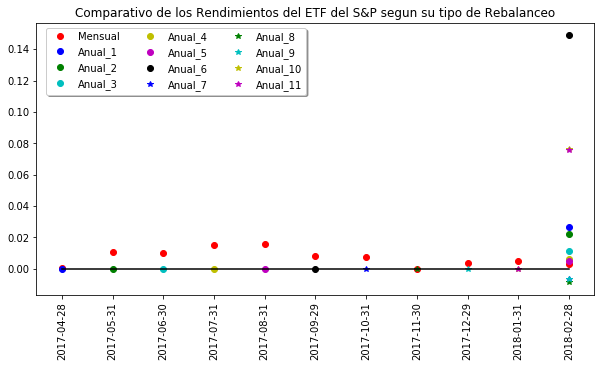

In [26]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
y = np.arange(11)
z_1 = np.arange(0,11,10)
z_2 = np.arange(1,11,9)
z_3 = np.arange(2,11,8)
z_4 = np.arange(3,11,7)
z_5 = np.arange(4,11,6)
z_6 = np.arange(5,11,5)
z_7 = np.arange(6,11,4)
z_8 = np.arange(7,11,3)
z_9 = np.arange(8,11,2)
z_10 = np.arange(9,11,1)
z_11 = np.arange(9,11,1)
line = np.arange(0,11,10)
plt.title('Comparativo de los Rendimientos del ETF del S&P segun su tipo de Rebalanceo')
plt.plot(y,Cap_Men, 'ro', label='Mensual')
plt.plot(z_1,Res_An_1, 'bo', label='Anual_1')
plt.plot(z_2,Res_An_2, 'go', label='Anual_2')
plt.plot(z_3,Res_An_3, 'co', label='Anual_3')
plt.plot(z_4,Res_An_4, 'yo', label='Anual_4')
plt.plot(z_5,Res_An_5, 'mo', label='Anual_5')
plt.plot(z_6,Res_An_6, 'ko', label='Anual_6')
plt.plot(z_7,Res_An_7, 'b*', label='Anual_7')
plt.plot(z_8,Res_An_8, 'g*', label='Anual_8')
plt.plot(z_9,Res_An_9, 'c*', label='Anual_9')
plt.plot(z_10,Res_An_10, 'y*', label='Anual_10')
plt.plot(z_11,Res_An_11, 'm*', label='Anual_11')
plt.plot(line, np.array([0,0]), 'k-')
plt.xticks(y,fechas, rotation='vertical')
plt.legend(loc='upper center', bbox_to_anchor=(.25, 1.), ncol=3, fancybox=True, shadow=True)
plt.show()

## Cuarta Parte: Métricas de Desempeño

In [24]:
# Importa los datos de Excel y los guarda en un diccionario llamado "d"
d = {} # Crea un Diccionario Vacío
quandl.ApiConfig.api_key = "My9ygJsz7yTDx_9jcneH" # Quandl API key
num_archivos = 12
etf = pd.read_csv('/Users/Valentina/Desktop/ITESO/Trading/Trading/Trading/Data/iShares-Core-SP-Mid-Cap-ETF_fund.csv')
etf['Shares Outstanding'] = etf['Shares Outstanding'].str.replace(',', '')
usd_rate = [0.0241,0.0241,0.0239,0.0240,0.0241,0.0241,0.0243,0.0243,0.0242,0.0242,0.0241]

In [25]:
series = ['Serie 1', 'Serie 2', 'Serie 3', 'Serie 4', 'Serie 5', 'Serie 6', 'Serie 7', 'Serie 8', 'Serie 9', 'Serie 10', 'Serie 11']
rend = np.array([Res_An_1[1],Res_An_2[1],Res_An_3[1],Res_An_4[1],Res_An_5[1],Res_An_6[1],Res_An_7[1],Res_An_8[1],Res_An_9[1],Res_An_10[1],Res_An_11[1]])*100
riesgo = [np.std(etf['NAV per Share'][0:23]),np.std(etf['NAV per Share'][24:46]),np.std(etf['NAV per Share'][47:70]),np.std(etf['NAV per Share'][71:92]),np.std(etf['NAV per Share'][93:115]),np.std(etf['NAV per Share'][116:138]),np.std(etf['NAV per Share'][139:162]),np.std(etf['NAV per Share'][163:187]),np.std(etf['NAV per Share'][188:200]),np.std(etf['NAV per Share'][201:223]),np.std(etf['NAV per Share'][224:250])]
sharpe = ((rend/100)-usd_rate)/riesgo
# Treynor
beta_etf = (np.cov(etf_valuee,usd_rate))
sistema = np.std(usd_rate)
no_sistema = np.std(etf_valuee)
beta_port = ((no_sistema/sistema)*beta_etf)[1][1]
treynor = (((rend/100)-usd_rate)/beta_port)/100
tabla = pd.DataFrame(index=series,columns=['Rend. Promedio %','Riesgo','Sharpe','Treynor %'])
tabla.index.name = "Series"
tabla['Rend. Promedio %'] = rend
tabla['Riesgo'] = riesgo
tabla['Sharpe'] = sharpe
tabla['Treynor %'] = treynor
tabla

,Rend. Promedio %,Riesgo,Sharpe,Treynor %
Series,,,,
Serie 1,2.656477,0.871363,0.002829,0.062832
Serie 2,2.231307,1.394797,-0.001281,-0.045553
Serie 3,1.128667,0.700455,-0.018007,-0.321540
Serie 4,0.655139,0.553863,-0.031503,-0.444801
Serie 5,0.509946,0.177165,-0.107248,-0.484363
Serie 6,14.888543,0.610361,0.204445,3.181038
Serie 7,-0.634525,0.358010,-0.085599,-0.781211
Serie 8,-0.858317,0.349830,-0.093998,-0.838260
Serie 9,-0.633042,0.251229,-0.121524,-0.778284


Conclusión:

Como resultado del análisis de los rendimientos se puede evidenciar especialmente que, al principio del periodo de estudio, el rebalanceo mensual brindaba mejores rendimientos comparado con los rebalanceos una vez al año; sin embargo, a medida que avanzaba el tiempo este va generando menos rentabilidad con los otros portafolios. Por lo que fue una buena estrategia en los primeros meses y aunque en los últimos meses no fue tan eficiente, la cartera al final del periodo de análisis dio un rendimiento de 0.00326. 

Por otro lado, los portafolios conformados por rebalanceos una vez al año presentaron diversos resultados, por lo que se consideraron diferentes medidas de desempeño para seleccionar el portafolio más eficiente de acuerdo al Índice de Sharpe, Índice de Treynor, el riesgo y la rentabilidad. Teniendo en cuenta los resultados, se llegó a la conclusión que los portafolios rebalanceados en el mes de septiembre del 2017, enero y febrero del 2018 fueron más eficientes en cuanto a la rentabilidad; a pesar de contar con mayor nivel de riesgo, estos portafolios cuentan con mayores unidades de rendimiento obtenido por cada unidad de riesgo y riesgo sistémico asumido. Por lo tanto, se podría considerar que estos portafolios son los ideales dentro del grupo de los conformado en este estudio.  

Así mismo, se conformaron portafolios con nivel bajo de riesgo; sin embargo, estos no son tan atractivos debido a que su rentabilidad obtenida fue muy baja llegando a ser negativa; por lo tanto, se puede decir que el rendimiento obtenido es menor a lo que se obtendría si se invierte en un activo libre de riesgo. Por lo anterior, se considera que los portafolios rebalanceados en los meses de octubre, noviembre y diciembre de 2017 no se les aplico la mejor estrategia y no son eficientes comparados con un activo libre de riesgo. 

Por último, se puede concluir, que el rebalanceo puede ser una estrategia efectiva como fue en el caso de los rebalanceos mensuales pero que en ocasiones esto puede causar una disminución del rendimiento; pero que al mismo tiempo es de suma importancia cambiar las participaciones de los activos en el portafolio con el fin obtener mejores rendimientos solo en el caso de realizarlos en el momento adecuado como ocurrió en el mes de septiembre del 2017.  